In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt #plotolásra
import matlab.engine #MATLABhoz
import time #teljesítmény mérésre

In [2]:
max_steps_per_episode =100

In [3]:
eng=matlab.engine.start_matlab()

In [4]:
model='NoControl';
eng.load_system(model)

0.0001220703125

In [5]:
eng.find_system(model,'Type','Block')

['NoControl/Actuator',
 'NoControl/Assertion',
 'NoControl/Clock',
 'NoControl/Constant1',
 'NoControl/Display',
 'NoControl/Plant',
 'NoControl/Relational\nOperator',
 'NoControl/Scope',
 'NoControl/Step',
 'NoControl/Sum',
 'NoControl/OUTPUT',
 'NoControl/Time',
 'NoControl/Error']

In [6]:
eng.workspace['model']=model

In [7]:
eng.get_param([model+'/Plant'],'Numerator')# példa blokk paraméter beolvasásra

['plant.Numerator{1,1}']

In [8]:
eng.workspace['plant']=eng.eval("tf(5,conv(conv([10 1],[4 1]),[1 1]))") #veszélyes, mivel elsőnek átalakítja valami python változóba
eng.workspace['control']=eng.eval("tf([3.51 1.229 0.08776],[0.351 1 0])")#s csak aztán adja át a matlabos változónak

In [9]:
eng.workspace['actuator']=1.0

In [10]:
eng.set_param(model,'SimulationCommand','update',nargout=0)

In [11]:
state=eng.get_param(model,'SimulationStatus')
hiba=0
state

'stopped'

In [12]:

start = time.time()
for i in range(1):
    eng.workspace['actuator']=1.0 #kezdeti init és paraméter átadás a workspacenek
    #Simulink modell elindítása
    eng.set_param(model, 'SimulationCommand', 'start', nargout=0);
    x=[]
    y=[]
    hibak=[]
    timesteps=0
    while (eng.get_param(model,'SimulationStatus')!=('stopped' or 'terminating')) and (max_steps_per_episode>timesteps) :
        if eng.get_param(model,'SimulationStatus')=='paused':
            #paraméterek írása és olvasása
            kimenet=eng.eval("get_param([model '/OUTPUT'],'RuntimeObject').InputPort(1).Data")
            ido=eng.eval("get_param([model '/Time'],'RuntimeObject').InputPort(1).Data")
            hiba=eng.eval("get_param([model '/Error'],'RuntimeObject').InputPort(1).Data")

            eng.workspace['actuator']=hiba
           # print(ido)
           # print(hiba)
            x.append(ido)
            y.append(kimenet)
            hibak.append(hiba)
            eng.set_param(model,'SimulationCommand','update',nargout=0) #szimulációs paraméterek beírása
            eng.set_param(model,'SimulationCommand','continue',nargout=0)#szimuláció folytatása
        #eng.pause(0.08) #érdekes?
        timesteps=timesteps+1
        #print(timesteps)
    eng.set_param(model,'SimulationCommand','stop',nargout=0) #szimuláció megállítása egy episode után
end = time.time()
print(end-start)

17.194249391555786


In [13]:
#plt.plot(x,y,x,hibak,'r--')
timesteps

100

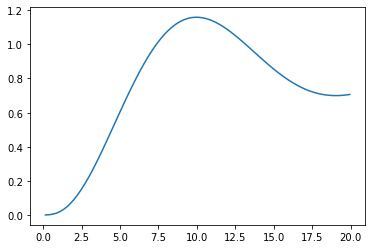

In [14]:
plt.plot(x,y)

In [15]:
num_states = 7 #ido + 6 elmúlt hiba
print("Size of State Space ->  {}".format(num_states))
num_actions = 1
print("Size of Action Space ->  {}".format(num_actions))
#hasracsapásra pár érték
upper_bound = 1
lower_bound = -1

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  7
Size of Action Space ->  1
Max Value of Action ->  1
Min Value of Action ->  -1


In [16]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [17]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [18]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    out = layers.Dense(256, activation="relu")(out)#+1 sor?----------------------
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [19]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [20]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.00002
actor_lr = 0.00001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 10000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)
#max steps per episode
#max_steps_per_episode = 100 #egyszer már megadtam

In [21]:
def simulation_step(action, timestep): #egy megállított állapotból átvisz a következő megállított állapotra
    eng.workspace['actuator']=action#IMPORTANT FLOAT LEGYEN NE INT!!!---> update hiba
    eng.set_param(model,'SimulationCommand','update',nargout=0) #szimulációs paraméterek beírása
    if timestep==0:
        eng.set_param(model, 'SimulationCommand', 'start', nargout=0)#Simulink modell elindítása
    else:    
        eng.set_param(model,'SimulationCommand','continue',nargout=0)#szimuláció folytatása
    #eng.pause(0.05)    
    status=eng.get_param(model,'SimulationStatus')    
    while (status!='paused') and ((status!=("stopped")) and (status!=("terminating"))):#megvárjuk míg lefut a szimulációs lépés
        eng.pause(0.05)
        status=eng.get_param(model,'SimulationStatus')
        print("Pausoltunk!")#lefutott
    #paraméterek kiolvasása
    if ((status!=("stopped")) and (status!=("terminating"))):
        kimenet=eng.eval("get_param([model '/OUTPUT'],'RuntimeObject').InputPort(1).Data")
        ido=eng.eval("get_param([model '/Time'],'RuntimeObject').InputPort(1).Data")
        hiba=eng.eval("get_param([model '/Error'],'RuntimeObject').InputPort(1).Data")

    return hiba, kimenet, ido

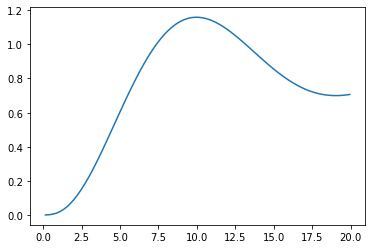

In [22]:
huba=1.0
xs=[]
ys=[]
sum_huba=0
timesteps=0
for i in range(100):
    huba,y,x=simulation_step(huba,timesteps)
    timesteps=timesteps+1
    #print(timesteps)
    #print(x)
    #print(y)
    xs.append(x)
    ys.append(y)
    sum_huba=1/(huba**2*10)+sum_huba
eng.set_param(model, 'SimulationCommand', 'stop', nargout=0)#Simulink modell elindítása
plt.plot(xs,ys)
#SIKER

In [23]:
simulation_step(0.0,0)

(1.0, 0.0, 0.15000000000000002)

In [24]:
eng.set_param(model, 'SimulationCommand', 'stop', nargout=0)
print(sum_huba)
timesteps

54085.17977651629


100

In [25]:
def step_value(hiba,prev_state,ido):
    state=prev_state
    state=np.append(state,hiba)
    state=np.delete(state,1)
    state[0]=ido
    state = tf.convert_to_tensor(state)
    #state = tf.expand_dims(state, 0) ez kell egyáltalán?
    reward=-hiba**2#reward kiszámítása
    done= False #fusson le mindig nyugodtan most még
    return state, reward, done

In [26]:
step_value(0.5,np.array([0,1.,1,1,1,1,1]),0.7)

(<tf.Tensor: shape=(7,), dtype=float64, numpy=array([0.7, 1. , 1. , 1. , 1. , 1. , 0.5])>,
 -0.25,
 False)

In [27]:
#!mkdir -p saved_models
#actor_model.save('saved_models/actor_model')
#critic_model.save('saved_models/critic_model')
#target_actor.save('saved_models/target_actor')
#target_critic.save('saved_models/target_critic')

In [28]:
actor_model = tf.keras.models.load_model('saved_models/actor_model')
critic_model = tf.keras.models.load_model('saved_models/critic_model')
target_actor = tf.keras.models.load_model('saved_models/target_actor')
target_critic = tf.keras.models.load_model('saved_models/target_critic')

In [29]:
target_critic.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 16)           128         input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 32)           544         dense_14[0][0]                   
_______________________________________________________________________________________

-28.880286972378162


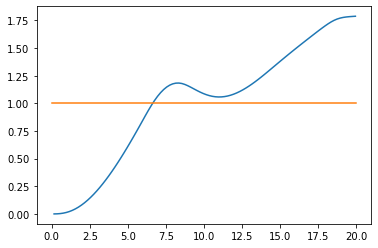

Episode * 0 * Avg Reward is ==> -28.880286972378162
-27.579263418203656


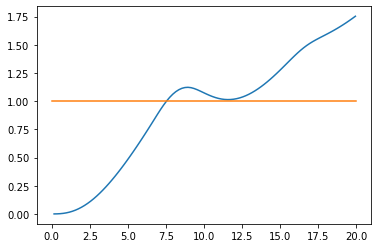

Episode * 1 * Avg Reward is ==> -28.22977519529091
-23.796618388888387


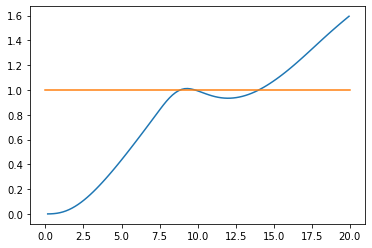

Episode * 2 * Avg Reward is ==> -26.7520562598234
-24.693870897465064


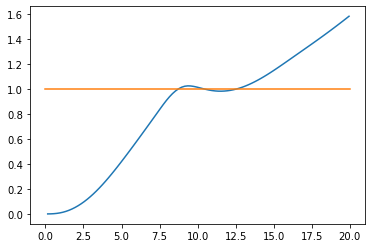

Episode * 3 * Avg Reward is ==> -26.237509919233815
-26.11016755978415


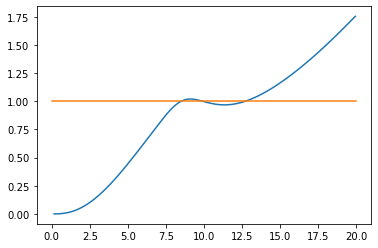

Episode * 4 * Avg Reward is ==> -26.212041447343882
-31.100904262463125


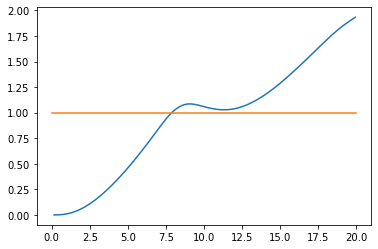

Episode * 5 * Avg Reward is ==> -27.026851916530422
-36.10462028426408


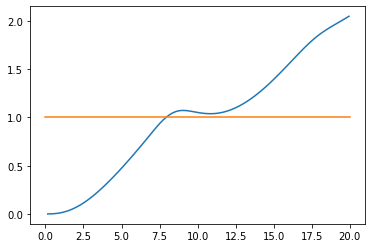

Episode * 6 * Avg Reward is ==> -28.323675969063803
-45.9779779715579


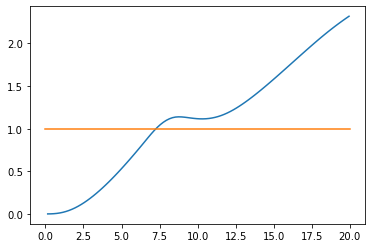

Episode * 7 * Avg Reward is ==> -30.530463719375565
-73.67381814430723


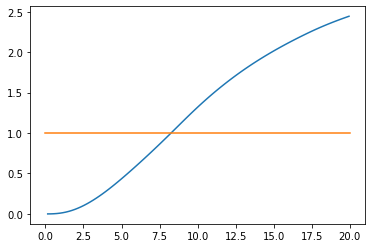

Episode * 8 * Avg Reward is ==> -35.32416976659019
-153.17806388100098


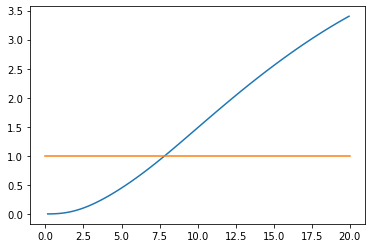

Episode * 9 * Avg Reward is ==> -47.10955917803127
-117.47092885494554


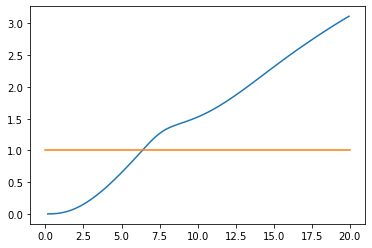

Episode * 10 * Avg Reward is ==> -55.968623366288014
-119.07160070505964


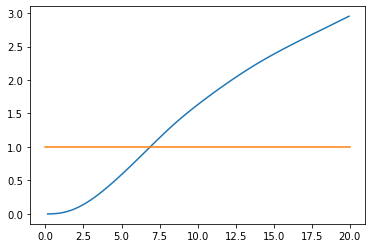

Episode * 11 * Avg Reward is ==> -65.1178570949736
-146.87971760411403


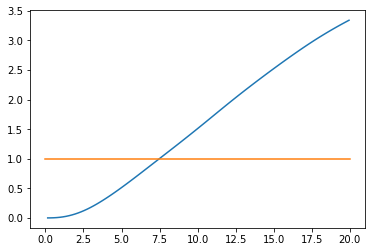

Episode * 12 * Avg Reward is ==> -77.42616701649618
-108.0822807690416


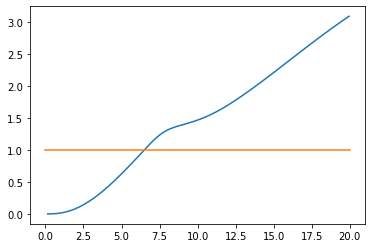

Episode * 13 * Avg Reward is ==> -85.76500800365383
-77.42182373184039


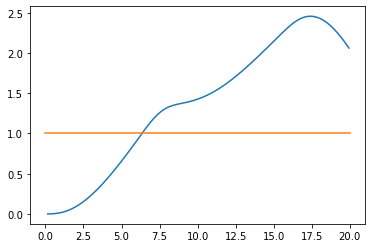

Episode * 14 * Avg Reward is ==> -90.89617362085946
-17.809536577230425


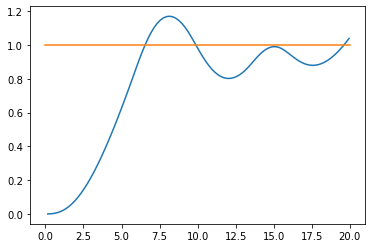

Episode * 15 * Avg Reward is ==> -89.56703685233619
-17.98305432069144


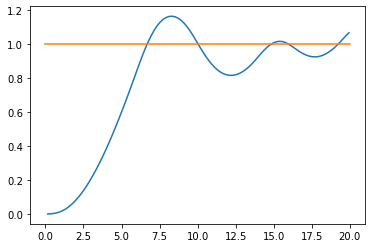

Episode * 16 * Avg Reward is ==> -87.75488025597892
-20.326195770534014


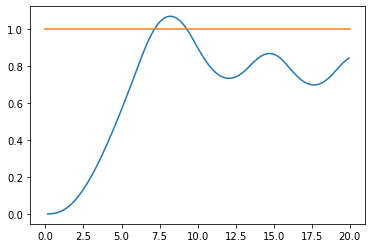

Episode * 17 * Avg Reward is ==> -85.18970203587652
-20.571687096387393


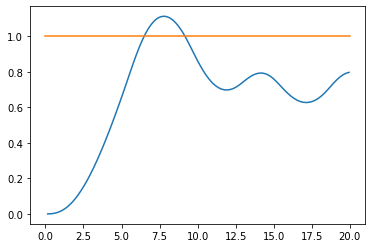

Episode * 18 * Avg Reward is ==> -79.87948893108455
-20.069693012760606


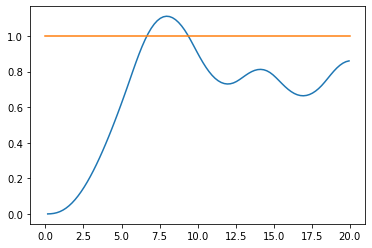

Episode * 19 * Avg Reward is ==> -66.56865184426051
-21.252090550635764


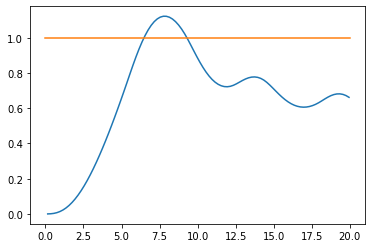

Episode * 20 * Avg Reward is ==> -56.946768013829534
-30.768542802346353


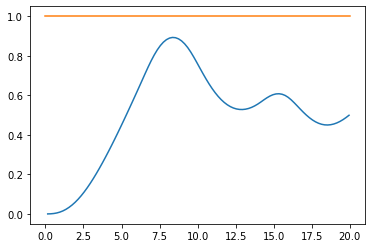

Episode * 21 * Avg Reward is ==> -48.1164622235582
-30.16226942698815


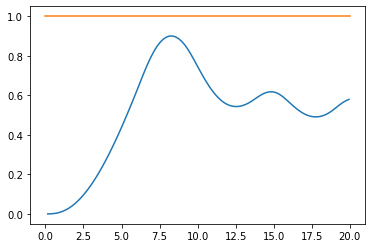

Episode * 22 * Avg Reward is ==> -36.444717405845616
-26.974427535760704


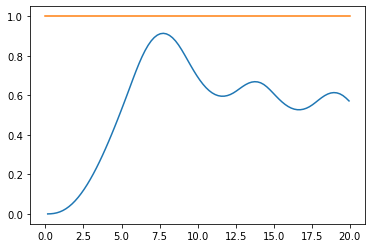

Episode * 23 * Avg Reward is ==> -28.33393208251752
-27.610170123876713


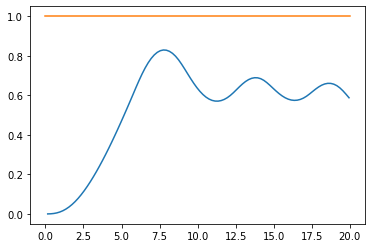

Episode * 24 * Avg Reward is ==> -23.352766721721157
-24.836506047450552


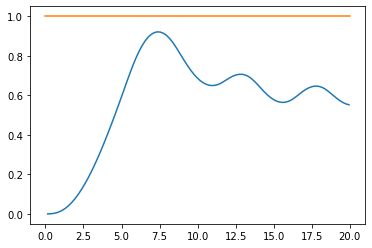

Episode * 25 * Avg Reward is ==> -24.055463668743165
-18.155594538234354


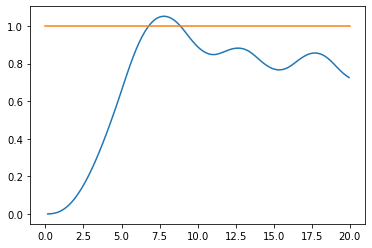

Episode * 26 * Avg Reward is ==> -24.072717690497463
-18.81545259724675


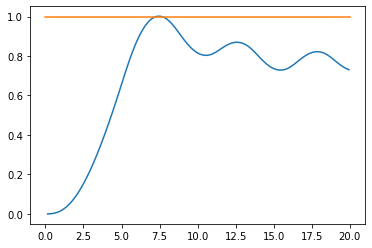

Episode * 27 * Avg Reward is ==> -23.921643373168735
-21.997946973362485


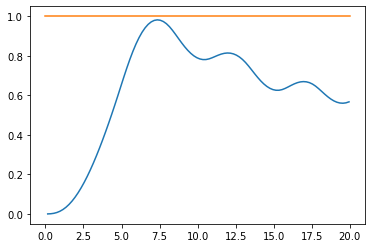

Episode * 28 * Avg Reward is ==> -24.06426936086624
-18.04763110355473


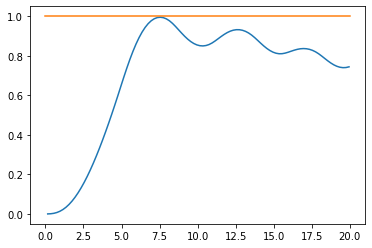

Episode * 29 * Avg Reward is ==> -23.862063169945653
-16.724142054010684


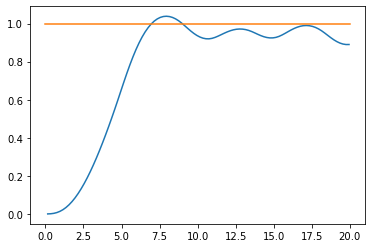

Episode * 30 * Avg Reward is ==> -23.40926832028315
-18.082954357305496


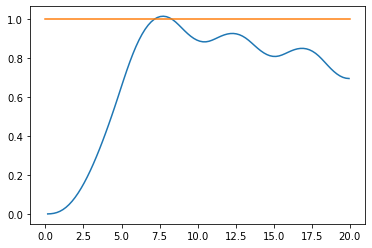

Episode * 31 * Avg Reward is ==> -22.14070947577906
-20.203129801241456


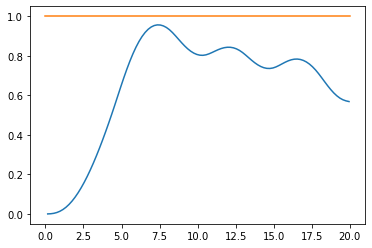

Episode * 32 * Avg Reward is ==> -21.144795513204393
-25.330515911188737


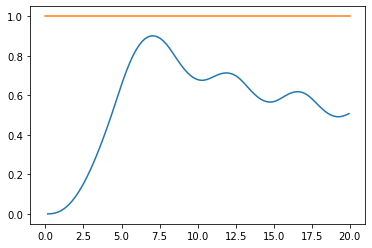

Episode * 33 * Avg Reward is ==> -20.980404350747197
-27.290462377357922


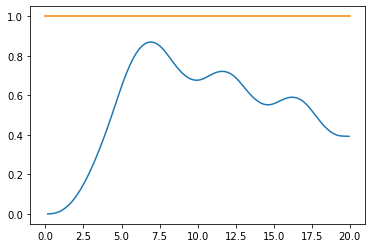

Episode * 34 * Avg Reward is ==> -20.94843357609532
-79.83207307286837


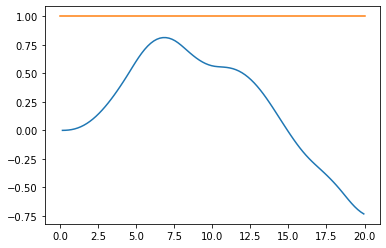

Episode * 35 * Avg Reward is ==> -26.4479902786371
-25.509838255521895


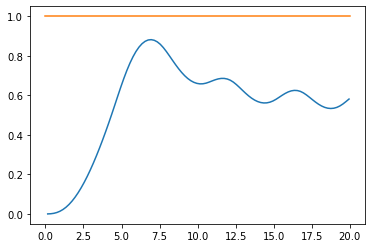

Episode * 36 * Avg Reward is ==> -27.183414650365854
-29.507580405047182


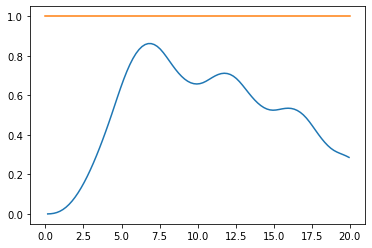

Episode * 37 * Avg Reward is ==> -28.252627431145896
-34.02382384526417


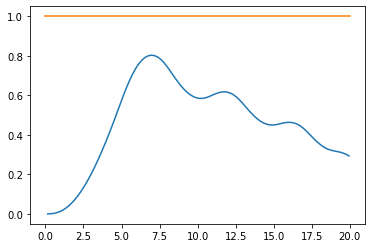

Episode * 38 * Avg Reward is ==> -29.45521511833607
-61.9976836317854


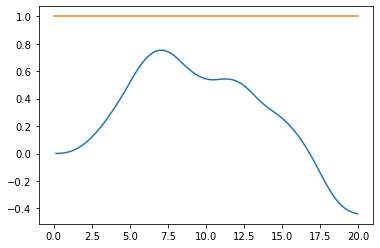

Episode * 39 * Avg Reward is ==> -33.850220371159125
-28.657550416437303


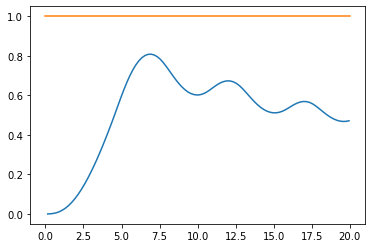

Episode * 40 * Avg Reward is ==> -35.043561207401794
-35.939613725656834


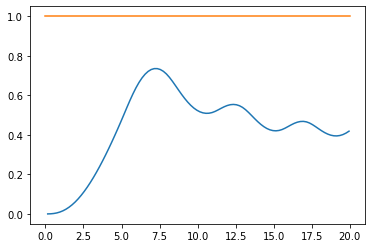

Episode * 41 * Avg Reward is ==> -36.829227144236924
-30.082855217707177


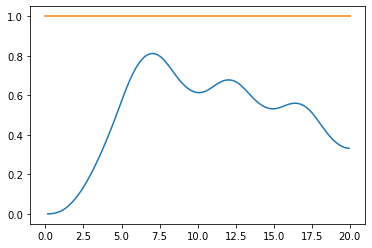

Episode * 42 * Avg Reward is ==> -37.817199685883494
-41.682144773994715


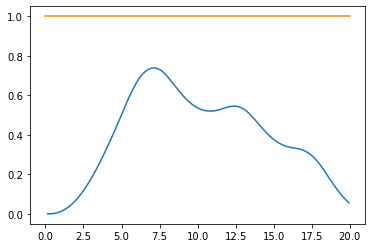

Episode * 43 * Avg Reward is ==> -39.45236257216409
-37.90457911604207


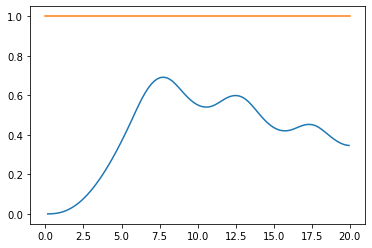

Episode * 44 * Avg Reward is ==> -40.513774246032504
-30.642752256694482


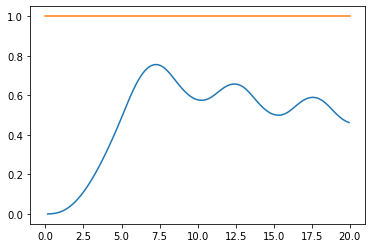

Episode * 45 * Avg Reward is ==> -35.59484216441513
-19.283486747772283


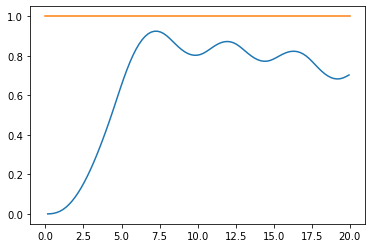

Episode * 46 * Avg Reward is ==> -34.97220701364016
-20.769223528532084


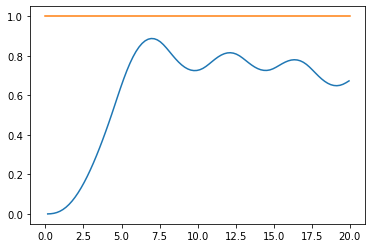

Episode * 47 * Avg Reward is ==> -34.09837132598865
-21.547646126278355


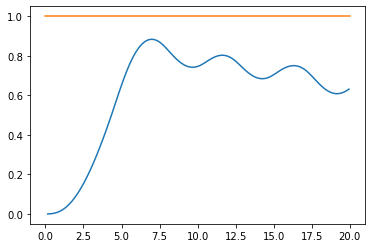

Episode * 48 * Avg Reward is ==> -32.850753554090076
-19.250470560140524


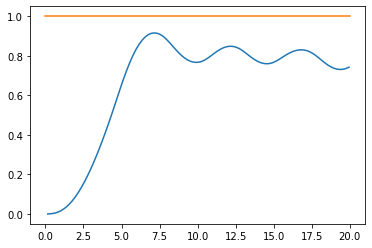

Episode * 49 * Avg Reward is ==> -28.576032246925582
-17.117271862958155


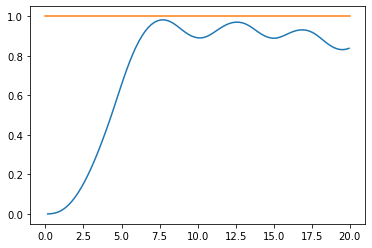

Episode * 50 * Avg Reward is ==> -27.422004391577666
-16.970010442816225


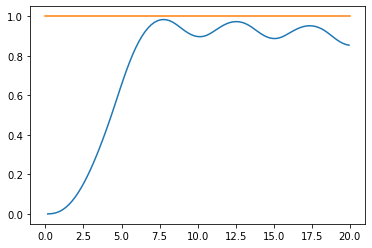

Episode * 51 * Avg Reward is ==> -25.525044063293606
-16.64070379640678


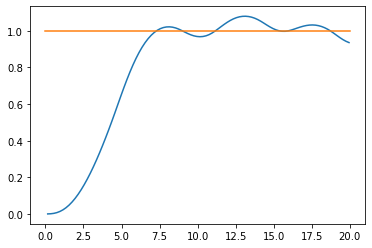

Episode * 52 * Avg Reward is ==> -24.180828921163567
-16.631649469964056


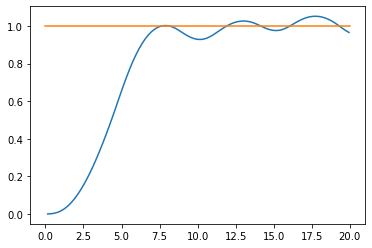

Episode * 53 * Avg Reward is ==> -21.6757793907605
-16.702879139944656


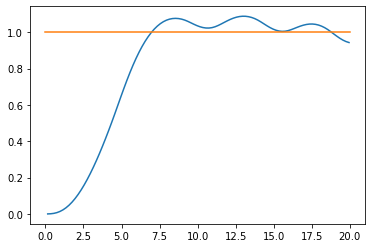

Episode * 54 * Avg Reward is ==> -19.555609393150757
-17.16187352187639


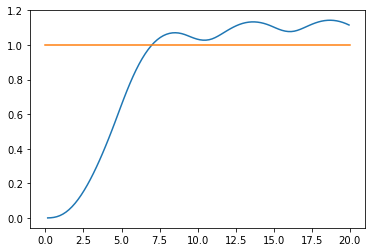

Episode * 55 * Avg Reward is ==> -18.20752151966895
-16.929479803718067


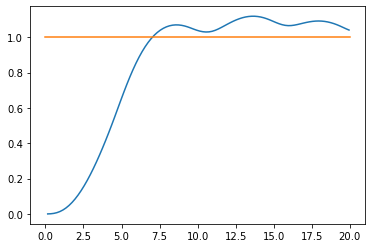

Episode * 56 * Avg Reward is ==> -17.97212082526353
-17.226730877484393


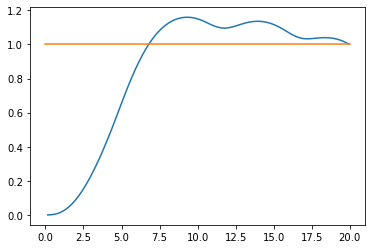

Episode * 57 * Avg Reward is ==> -17.617871560158758
-16.79916383897106


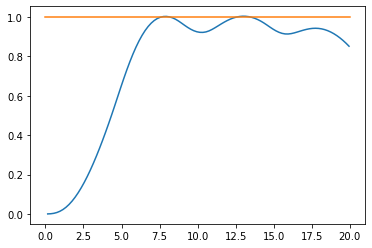

Episode * 58 * Avg Reward is ==> -17.14302333142803
-19.53756624798446


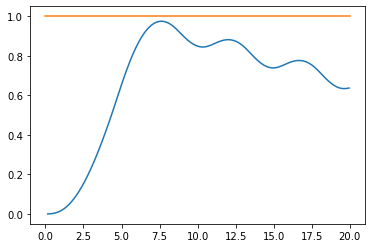

Episode * 59 * Avg Reward is ==> -17.171732900212426
-20.332604144559184


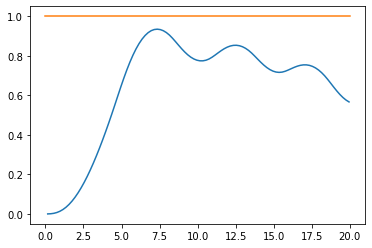

Episode * 60 * Avg Reward is ==> -17.49326612837253
-19.8294467144451


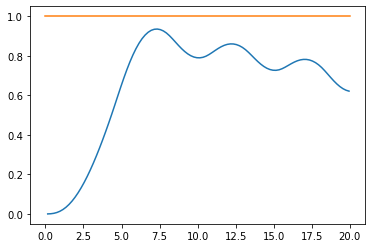

Episode * 61 * Avg Reward is ==> -17.779209755535415
-24.193973929308935


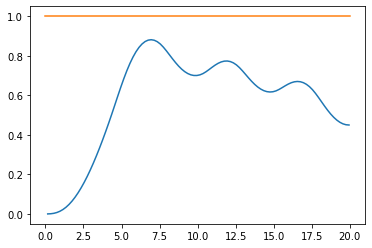

Episode * 62 * Avg Reward is ==> -18.53453676882563
-24.859484099639715


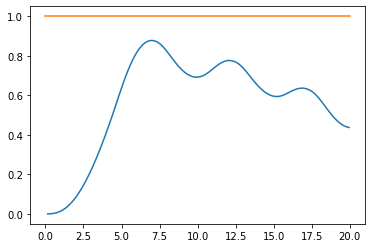

Episode * 63 * Avg Reward is ==> -19.357320231793192
-27.243690877656594


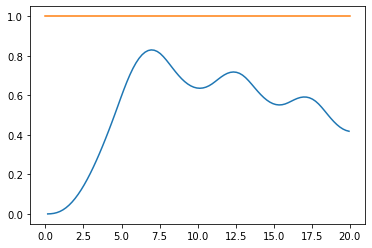

Episode * 64 * Avg Reward is ==> -20.41140140556439
-29.01216114156284


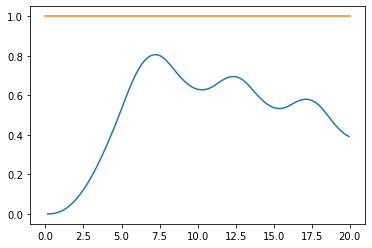

Episode * 65 * Avg Reward is ==> -21.596430167533036
-34.7233666662568


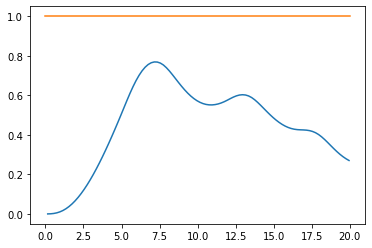

Episode * 66 * Avg Reward is ==> -23.375818853786907
-37.00392955032342


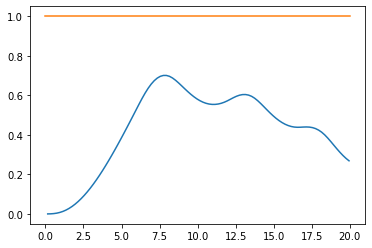

Episode * 67 * Avg Reward is ==> -25.353538721070812
-42.60469228321818


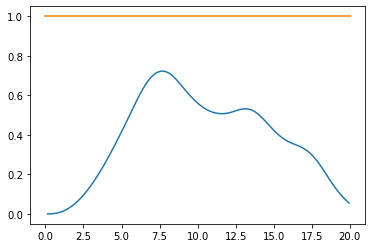

Episode * 68 * Avg Reward is ==> -27.93409156549552
-49.358957826494034


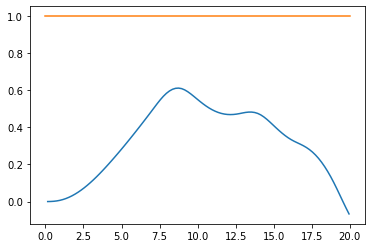

Episode * 69 * Avg Reward is ==> -30.91623072334648
-34.18443211466249


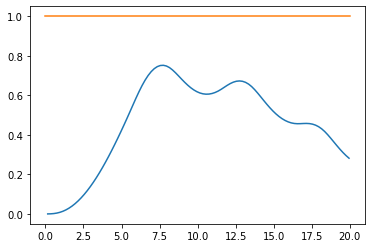

Episode * 70 * Avg Reward is ==> -32.30141352035681
-38.432212143850286


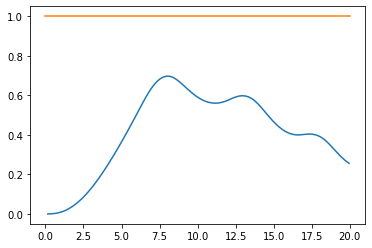

Episode * 71 * Avg Reward is ==> -34.16169006329733
-32.39307405109795


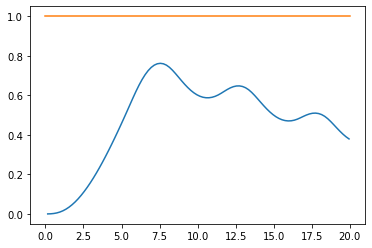

Episode * 72 * Avg Reward is ==> -34.98160007547623
-30.619373813835658


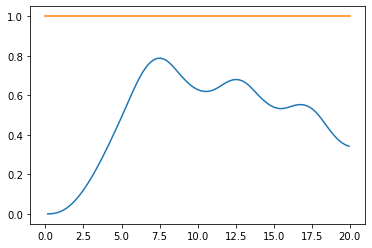

Episode * 73 * Avg Reward is ==> -35.55758904689582
-32.72030263458723


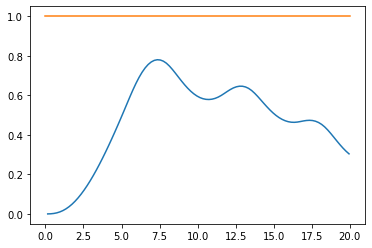

Episode * 74 * Avg Reward is ==> -36.10525022258889
-37.74419465813421


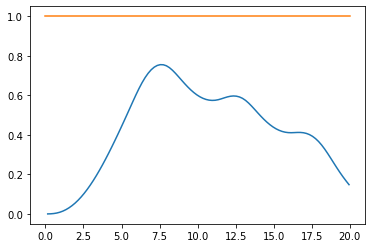

Episode * 75 * Avg Reward is ==> -36.97845357424603
-33.69431106759539


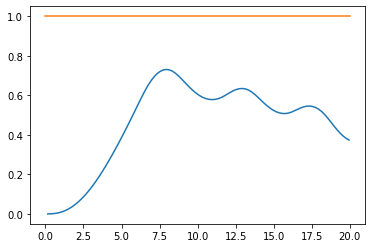

Episode * 76 * Avg Reward is ==> -36.87554801437989
-25.59897703699222


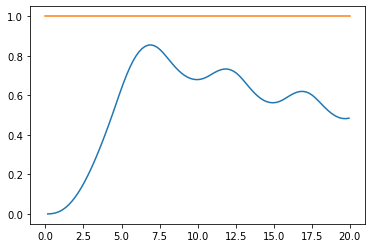

Episode * 77 * Avg Reward is ==> -35.73505276304677
-26.90349871517916


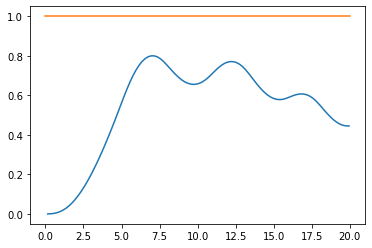

Episode * 78 * Avg Reward is ==> -34.16493340624287
-28.400914112089012


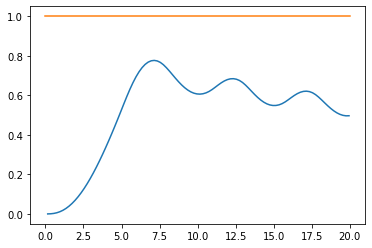

Episode * 79 * Avg Reward is ==> -32.069129034802366
-28.699431225807874


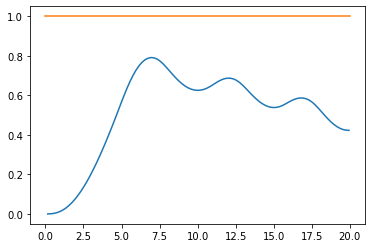

Episode * 80 * Avg Reward is ==> -31.5206289459169
-33.225754655614836


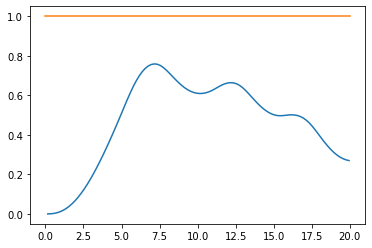

Episode * 81 * Avg Reward is ==> -30.999983197093353
-33.57871701987664


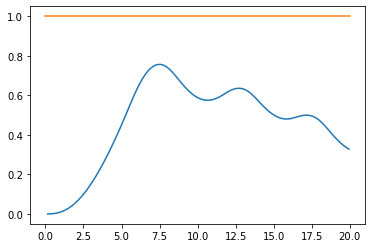

Episode * 82 * Avg Reward is ==> -31.118547493971228
-30.62217146670743


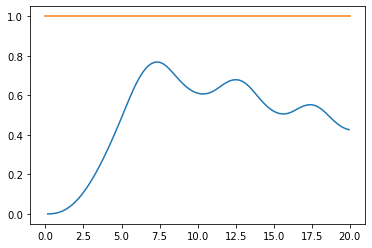

Episode * 83 * Avg Reward is ==> -31.1188272592584
-34.085192941155306


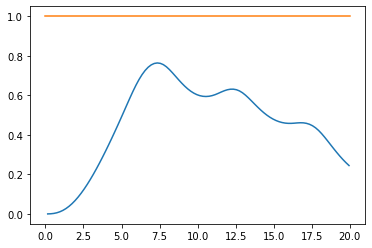

Episode * 84 * Avg Reward is ==> -31.255316289915207
-62.332657074325816


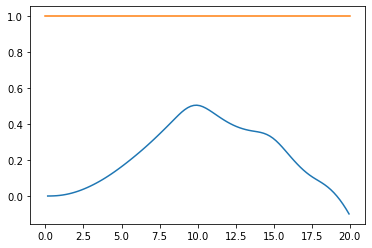

Episode * 85 * Avg Reward is ==> -33.71416253153437
-80.7651103577188


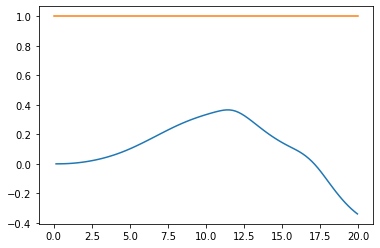

Episode * 86 * Avg Reward is ==> -38.42124246054671
-85.17370017220784


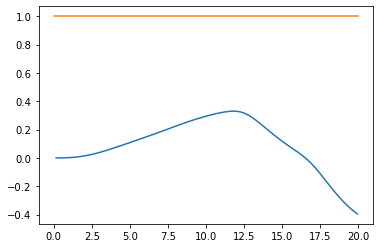

Episode * 87 * Avg Reward is ==> -44.37871477406827
-104.69059844160888


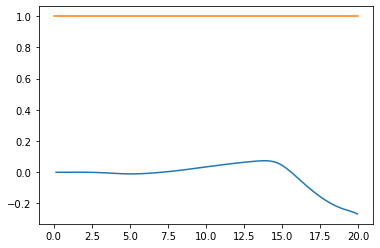

Episode * 88 * Avg Reward is ==> -52.15742474671125
-108.51849112586447


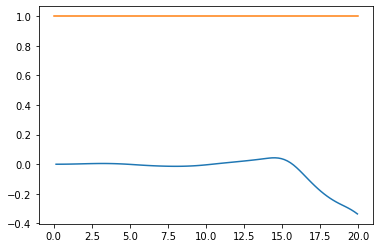

Episode * 89 * Avg Reward is ==> -60.16918244808879
-172.22148643219387


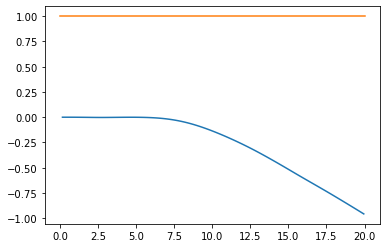

Episode * 90 * Avg Reward is ==> -74.52138796872738
-279.84578498426333


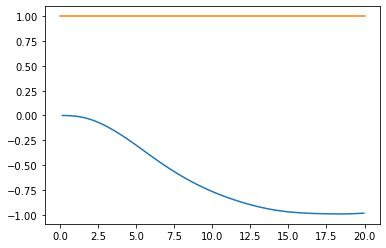

Episode * 91 * Avg Reward is ==> -99.18339100159224
-158.64562924701667


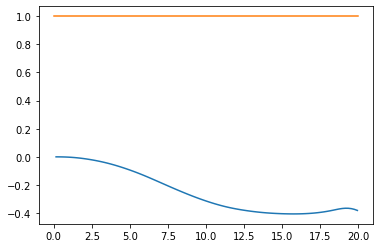

Episode * 92 * Avg Reward is ==> -111.69008222430625
-82.71828339321438


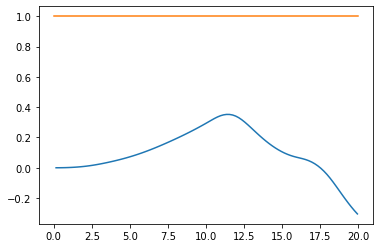

Episode * 93 * Avg Reward is ==> -116.89969341695692
-86.41877040301674


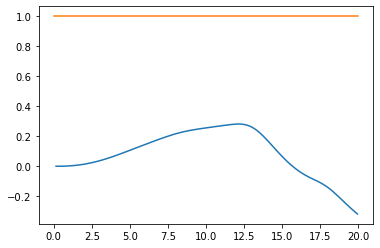

Episode * 94 * Avg Reward is ==> -122.13305116314307
-123.86114945096432


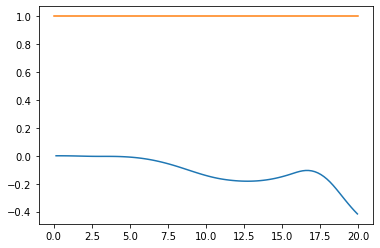

Episode * 95 * Avg Reward is ==> -128.28590040080692
-96.74891341869514


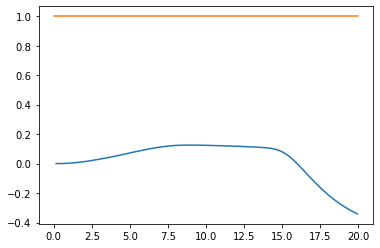

Episode * 96 * Avg Reward is ==> -129.88428070690458
-127.85682740271533


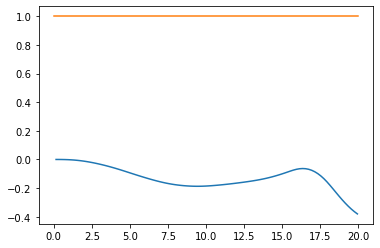

Episode * 97 * Avg Reward is ==> -134.1525934299553
-57.053008550688304


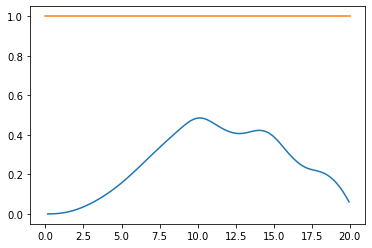

Episode * 98 * Avg Reward is ==> -129.38883444086326
-41.30147897511804


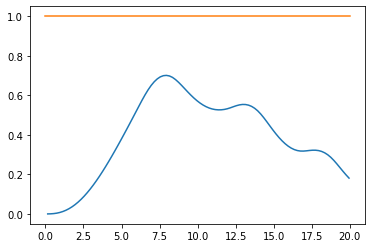

Episode * 99 * Avg Reward is ==> -122.66713322578858
-35.787556326872384


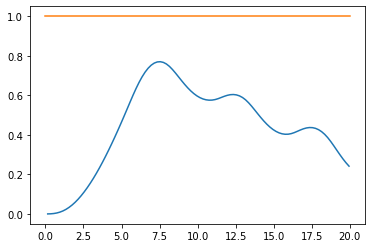

Episode * 100 * Avg Reward is ==> -109.02374021525648
-35.11817671231408


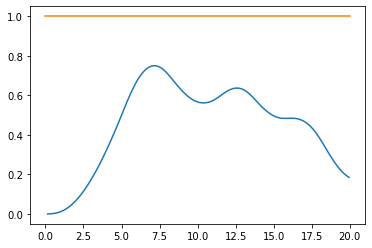

Episode * 101 * Avg Reward is ==> -84.55097938806153
-34.910789585848725


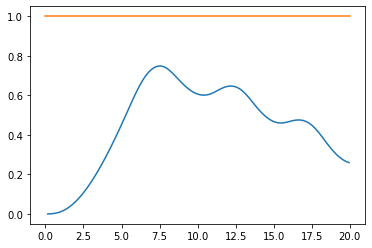

Episode * 102 * Avg Reward is ==> -72.17749542194473
-33.931456717840675


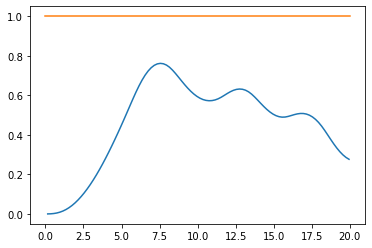

Episode * 103 * Avg Reward is ==> -67.29881275440736
-28.897125088763765


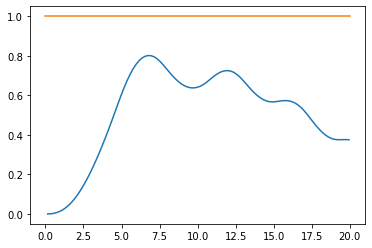

Episode * 104 * Avg Reward is ==> -61.54664822298207
-28.39278633510606


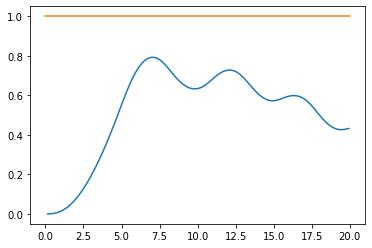

Episode * 105 * Avg Reward is ==> -51.99981191139625
-23.765223473756816


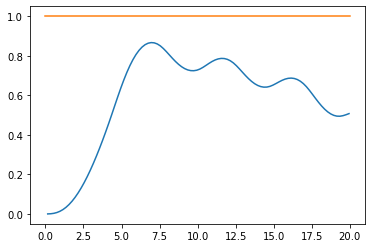

Episode * 106 * Avg Reward is ==> -44.70144291690241
-20.12754878780417


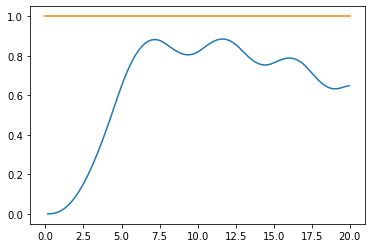

Episode * 107 * Avg Reward is ==> -33.9285150554113
-26.80075622044152


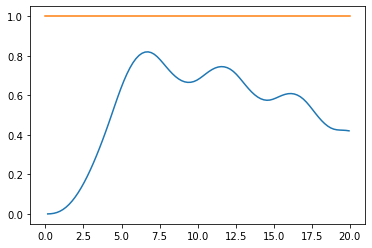

Episode * 108 * Avg Reward is ==> -30.903289822386625
-26.957221014860647


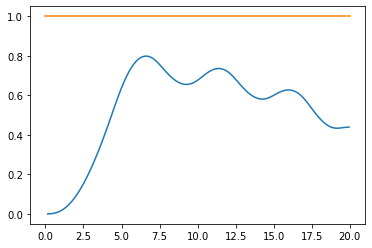

Episode * 109 * Avg Reward is ==> -29.468864026360883
-23.27526402050393


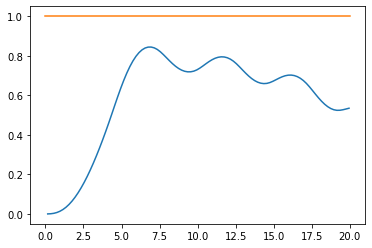

Episode * 110 * Avg Reward is ==> -28.217634795724035
-21.780903942035174


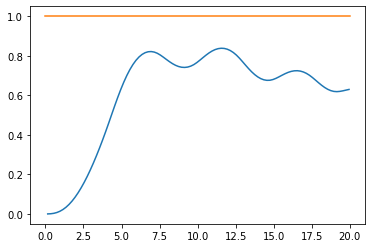

Episode * 111 * Avg Reward is ==> -26.883907518696144
-19.26881378275565


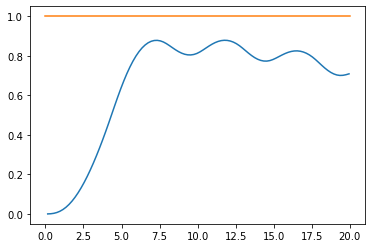

Episode * 112 * Avg Reward is ==> -25.31970993838684
-19.770612865471005


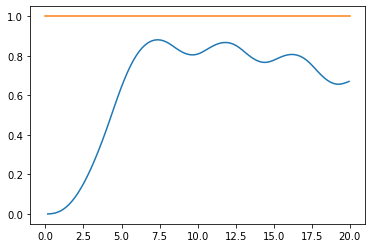

Episode * 113 * Avg Reward is ==> -23.903625553149872
-24.343399704047165


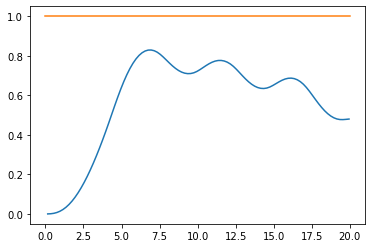

Episode * 114 * Avg Reward is ==> -23.44825301467821
-29.616478826680275


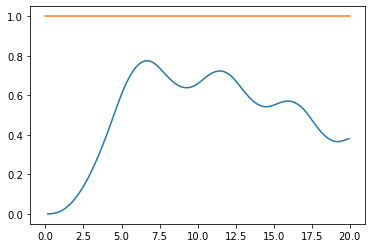

Episode * 115 * Avg Reward is ==> -23.57062226383563
-33.70450118763185


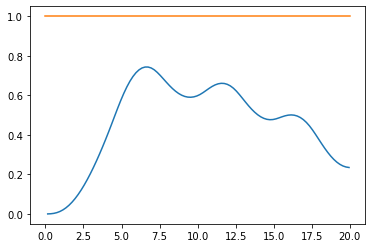

Episode * 116 * Avg Reward is ==> -24.564550035223135
-37.63485904040387


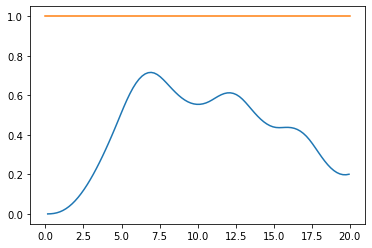

Episode * 117 * Avg Reward is ==> -26.31528106048311
-30.269657414696475


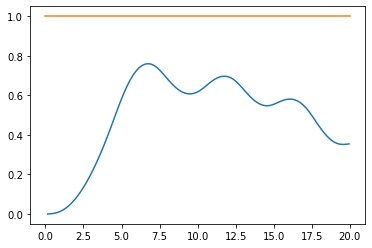

Episode * 118 * Avg Reward is ==> -26.662171179908604
-29.83012380248507


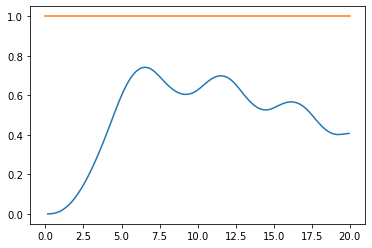

Episode * 119 * Avg Reward is ==> -26.949461458671045
-30.589781809766354


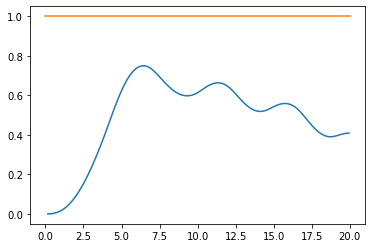

Episode * 120 * Avg Reward is ==> -27.68091323759729
-30.554326325929086


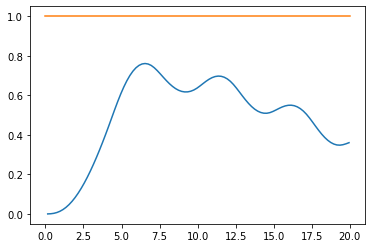

Episode * 121 * Avg Reward is ==> -28.55825547598668
-24.896865149840462


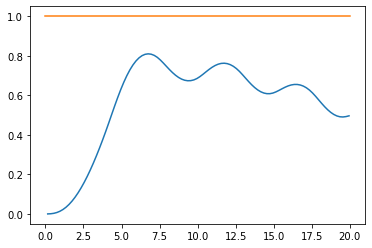

Episode * 122 * Avg Reward is ==> -29.121060612695157
-24.02643593570481


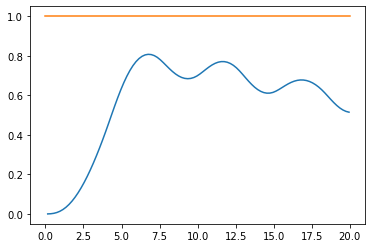

Episode * 123 * Avg Reward is ==> -29.54664291971854
-19.541054683992687


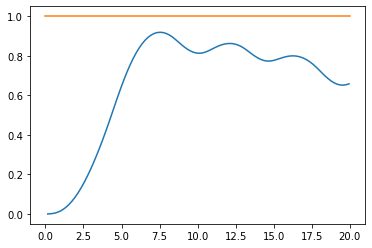

Episode * 124 * Avg Reward is ==> -29.06640841771309
-19.237722335370144


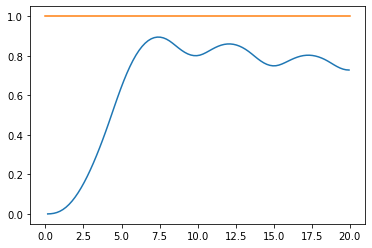

Episode * 125 * Avg Reward is ==> -28.028532768582085
-16.845222987967


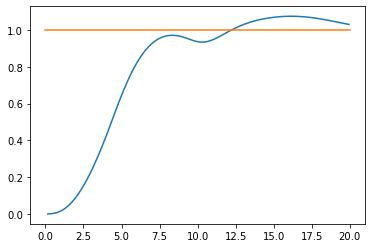

Episode * 126 * Avg Reward is ==> -26.342604948615595
-20.37874429719702


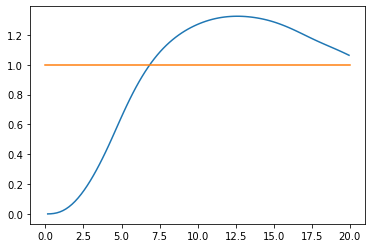

Episode * 127 * Avg Reward is ==> -24.616993474294908
-17.101422864523247


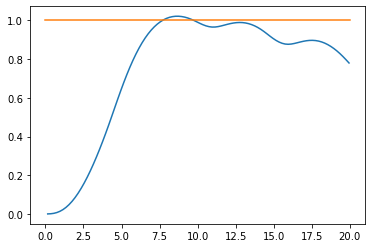

Episode * 128 * Avg Reward is ==> -23.300170019277587
-17.244776841997542


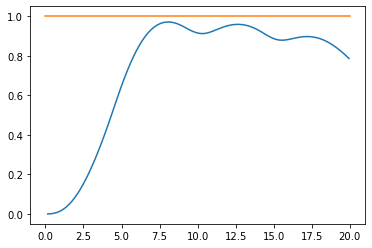

Episode * 129 * Avg Reward is ==> -22.04163532322884
-17.87252683335264


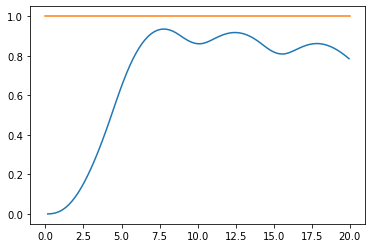

Episode * 130 * Avg Reward is ==> -20.769909825587465
-19.35720998927802


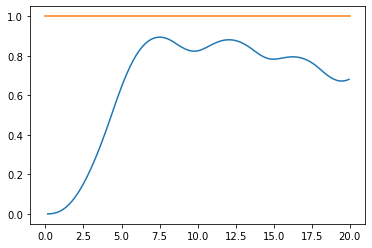

Episode * 131 * Avg Reward is ==> -19.650198191922364
-17.029577783650666


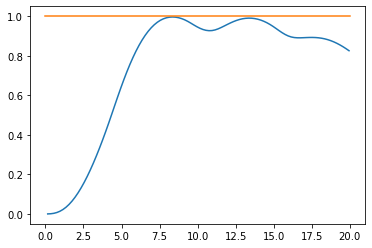

Episode * 132 * Avg Reward is ==> -18.86346945530338
-17.308009447796195


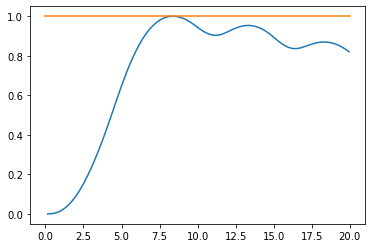

Episode * 133 * Avg Reward is ==> -18.191626806512517
-17.33561983777333


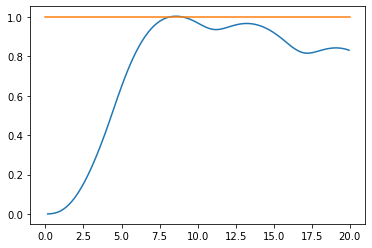

Episode * 134 * Avg Reward is ==> -17.971083321890582
-18.44519615719358


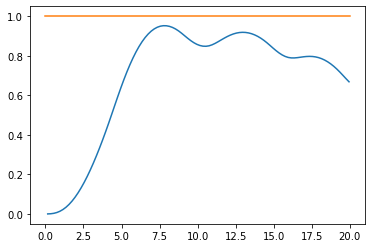

Episode * 135 * Avg Reward is ==> -17.891830704072923
-20.149155908629112


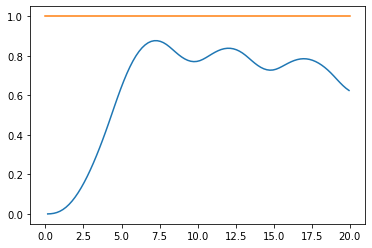

Episode * 136 * Avg Reward is ==> -18.22222399613914
-19.842451295319968


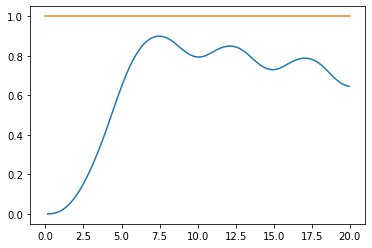

Episode * 137 * Avg Reward is ==> -18.16859469595143
-22.800268676236836


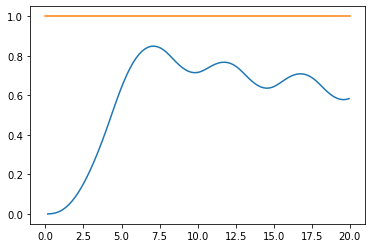

Episode * 138 * Avg Reward is ==> -18.73847927712279
-21.266758050993626


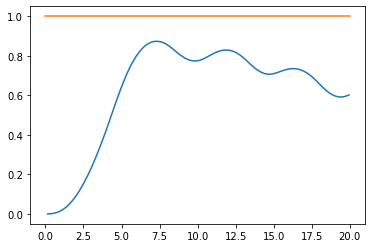

Episode * 139 * Avg Reward is ==> -19.140677398022397
-19.869318943849564


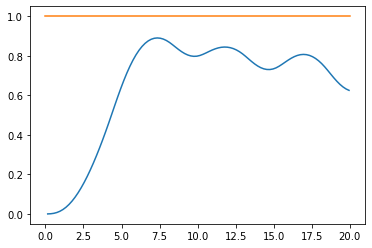

Episode * 140 * Avg Reward is ==> -19.340356609072085
-20.2465628834037


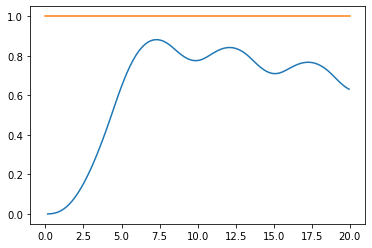

Episode * 141 * Avg Reward is ==> -19.429291898484657
-21.80739763417638


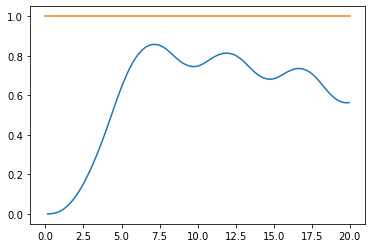

Episode * 142 * Avg Reward is ==> -19.90707388353723
-24.344900058196245


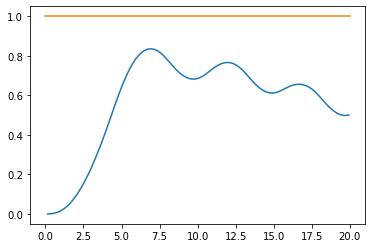

Episode * 143 * Avg Reward is ==> -20.610762944577232
-22.719222962125187


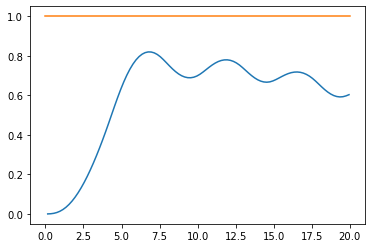

Episode * 144 * Avg Reward is ==> -21.149123257012416
-25.76800501386753


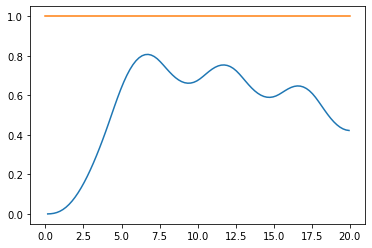

Episode * 145 * Avg Reward is ==> -21.881404142679816
-33.52167048399797


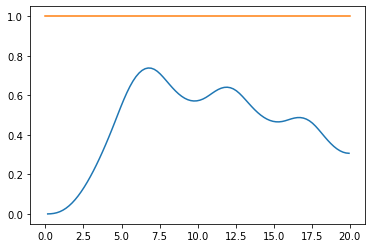

Episode * 146 * Avg Reward is ==> -23.218655600216703
-35.24088002880715


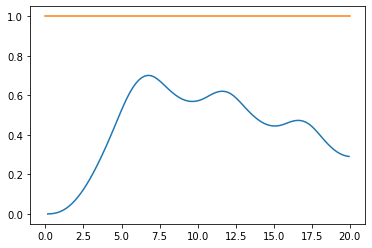

Episode * 147 * Avg Reward is ==> -24.758498473565417
-39.74729312091174


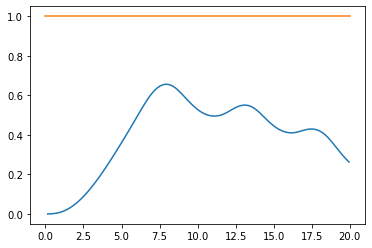

Episode * 148 * Avg Reward is ==> -26.453200918032913
-45.06378937207168


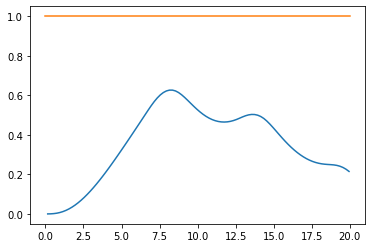

Episode * 149 * Avg Reward is ==> -28.832904050140712
-50.27544382602147


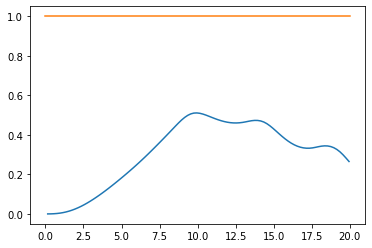

Episode * 150 * Avg Reward is ==> -31.87351653835791
-35.82693756238814


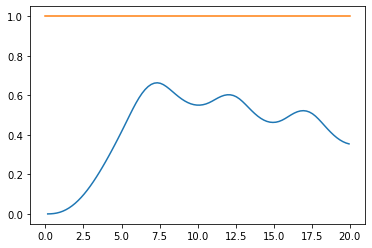

Episode * 151 * Avg Reward is ==> -33.43155400625635
-39.35991296914681


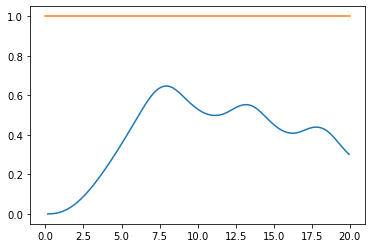

Episode * 152 * Avg Reward is ==> -35.186805539753394
-31.736947238032947


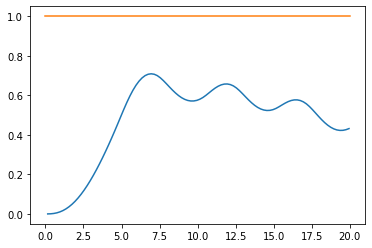

Episode * 153 * Avg Reward is ==> -35.92601025773706
-31.74689459567016


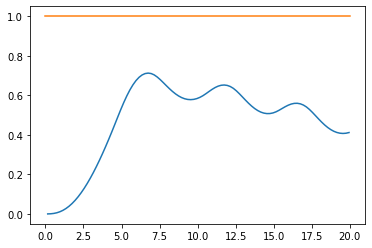

Episode * 154 * Avg Reward is ==> -36.82877742109156
-31.78258001819864


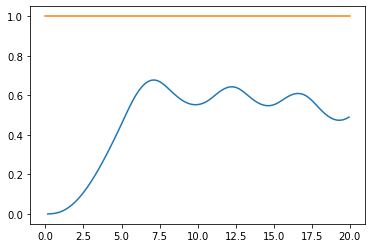

Episode * 155 * Avg Reward is ==> -37.43023492152467
-31.946665463475895


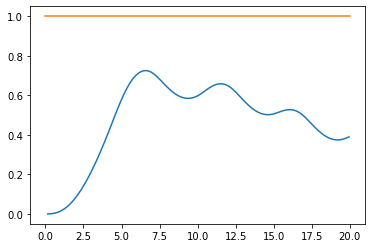

Episode * 156 * Avg Reward is ==> -37.272734419472464
-36.93262300768223


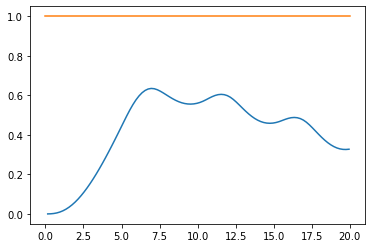

Episode * 157 * Avg Reward is ==> -37.441908717359965
-34.72248651025308


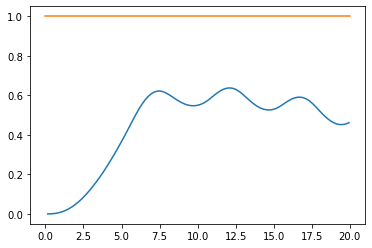

Episode * 158 * Avg Reward is ==> -36.93942805629411
-20.429255249543804


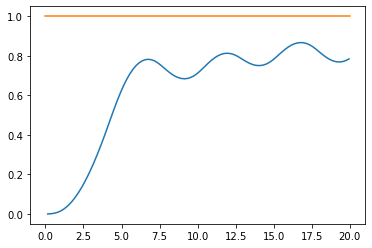

Episode * 159 * Avg Reward is ==> -34.47597464404132
-19.856478163523978


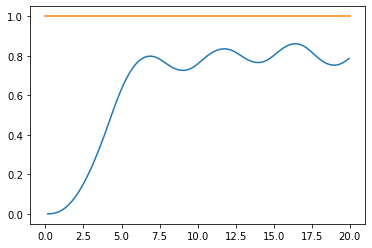

Episode * 160 * Avg Reward is ==> -31.434078077791575
-22.83319631646653


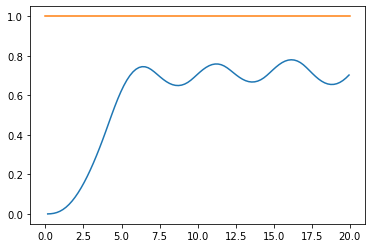

Episode * 161 * Avg Reward is ==> -30.13470395319941
-25.83985830085204


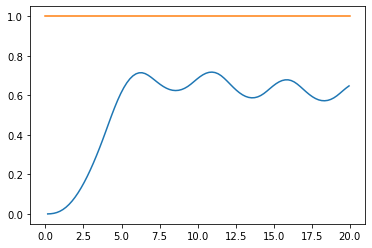

Episode * 162 * Avg Reward is ==> -28.78269848636993
-28.519408516673483


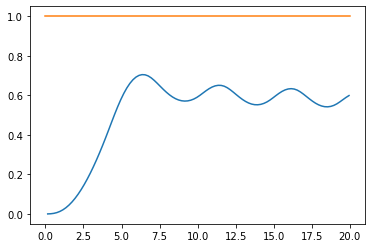

Episode * 163 * Avg Reward is ==> -28.460944614233984
-30.49951528280445


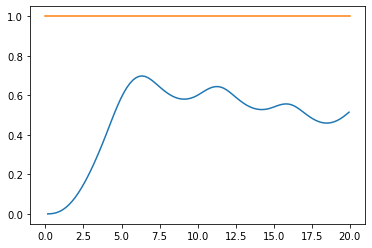

Episode * 164 * Avg Reward is ==> -28.336206682947413
-31.4256444961373


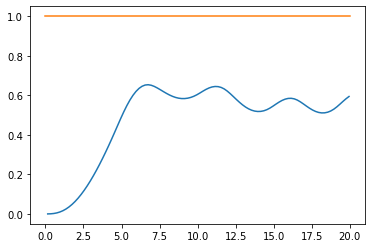

Episode * 165 * Avg Reward is ==> -28.30051313074128
-26.98392299640174


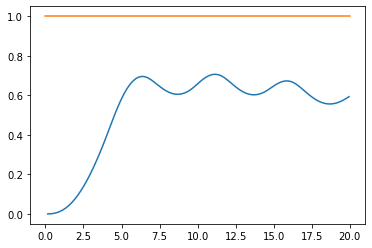

Episode * 166 * Avg Reward is ==> -27.80423888403386
-33.01218180503718


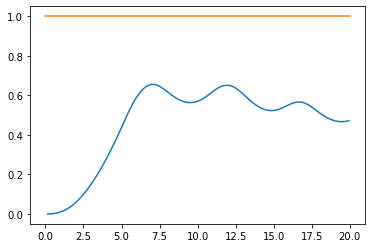

Episode * 167 * Avg Reward is ==> -27.412194763769357
-37.72148454781353


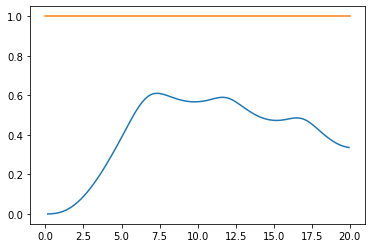

Episode * 168 * Avg Reward is ==> -27.712094567525405
-40.896937417964665


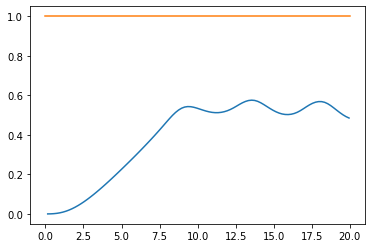

Episode * 169 * Avg Reward is ==> -29.758862784367487
-27.547420223135042


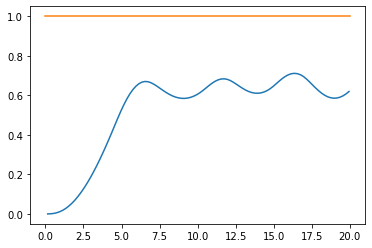

Episode * 170 * Avg Reward is ==> -30.527956990328597
-25.76042604201523


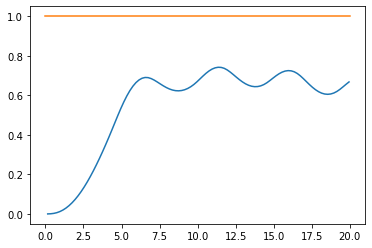

Episode * 171 * Avg Reward is ==> -30.820679962883464
-21.061613902285057


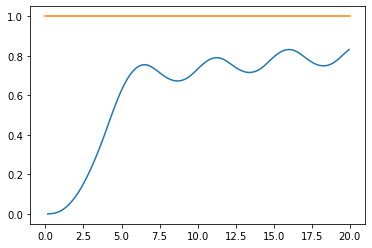

Episode * 172 * Avg Reward is ==> -30.34285552302677
-20.50368028096335


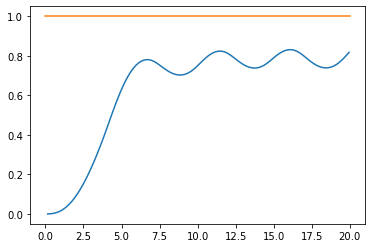

Episode * 173 * Avg Reward is ==> -29.541282699455756
-18.86534198157892


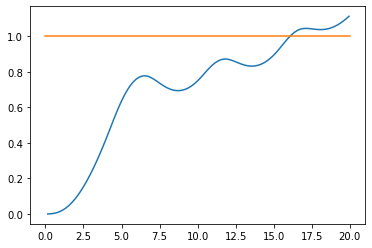

Episode * 174 * Avg Reward is ==> -28.377865369333204
-20.742058492506636


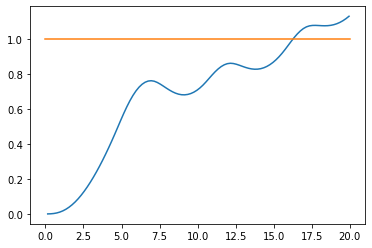

Episode * 175 * Avg Reward is ==> -27.309506768970135
-20.259931758428415


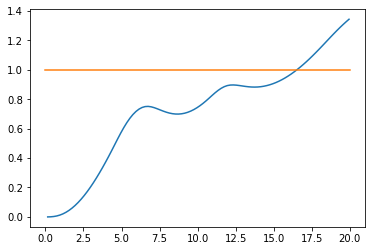

Episode * 176 * Avg Reward is ==> -26.6371076451728
-22.005743765914136


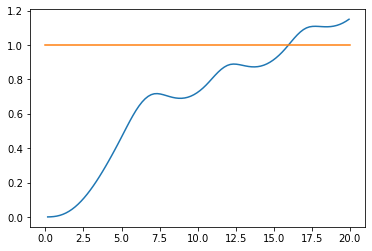

Episode * 177 * Avg Reward is ==> -25.536463841260503
-20.754847149283073


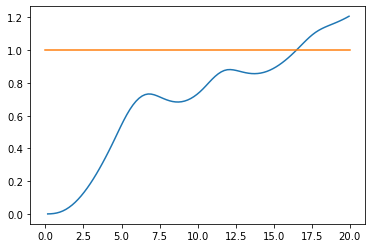

Episode * 178 * Avg Reward is ==> -23.839800101407455
-22.82698477979956


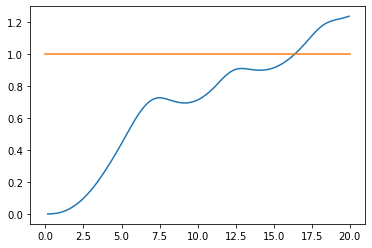

Episode * 179 * Avg Reward is ==> -22.03280483759094
-21.296862897367795


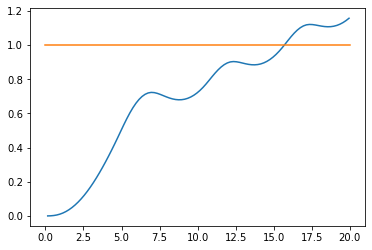

Episode * 180 * Avg Reward is ==> -21.40774910501422
-19.25846525390448


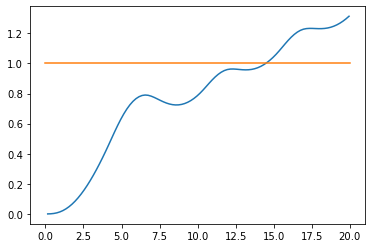

Episode * 181 * Avg Reward is ==> -20.757553026203144
-20.02413094794333


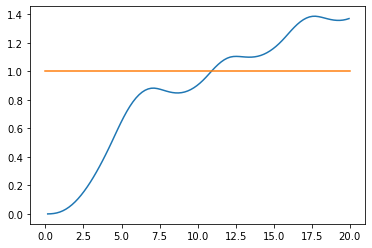

Episode * 182 * Avg Reward is ==> -20.65380473076897
-21.15109749185691


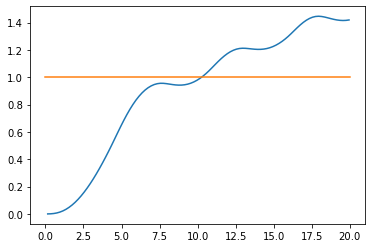

Episode * 183 * Avg Reward is ==> -20.718546451858323
-18.741034246030843


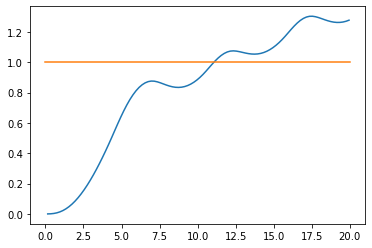

Episode * 184 * Avg Reward is ==> -20.70611567830352
-20.654540632600416


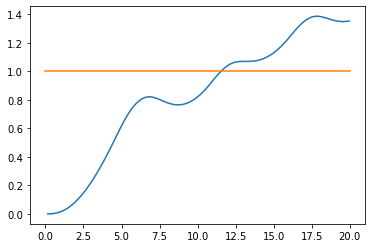

Episode * 185 * Avg Reward is ==> -20.697363892312893
-17.812244326770937


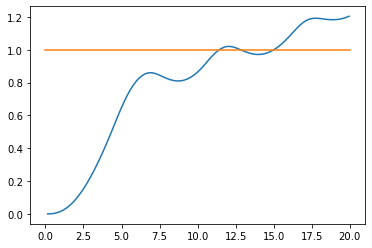

Episode * 186 * Avg Reward is ==> -20.45259514914715
-20.47931823088577


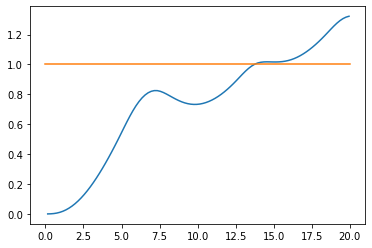

Episode * 187 * Avg Reward is ==> -20.29995259564431
-21.683240472517575


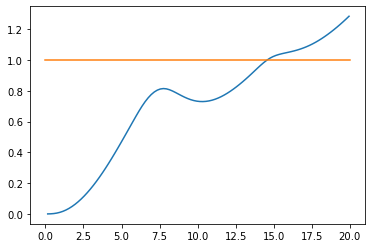

Episode * 188 * Avg Reward is ==> -20.392791927967764
-24.92974895819565


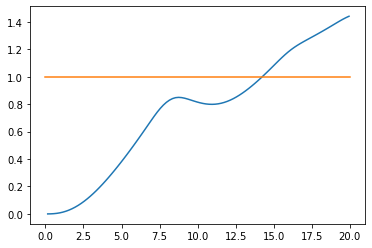

Episode * 189 * Avg Reward is ==> -20.603068345807372
-23.879937141570025


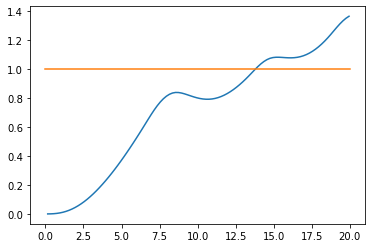

Episode * 190 * Avg Reward is ==> -20.861375770227593
-19.26431871749027


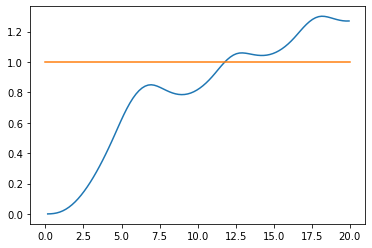

Episode * 191 * Avg Reward is ==> -20.861961116586173
-20.0667996243579


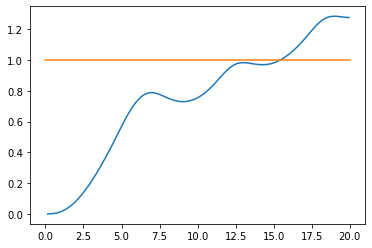

Episode * 192 * Avg Reward is ==> -20.866227984227628
-19.508155573840575


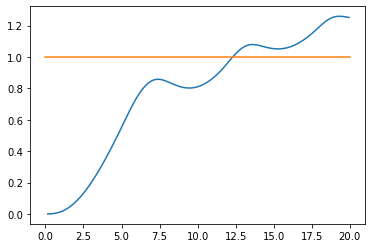

Episode * 193 * Avg Reward is ==> -20.701933792425997
-21.441437698559287


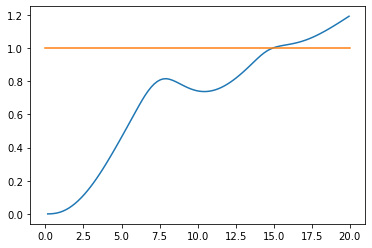

Episode * 194 * Avg Reward is ==> -20.971974137678842
-25.458655063688923


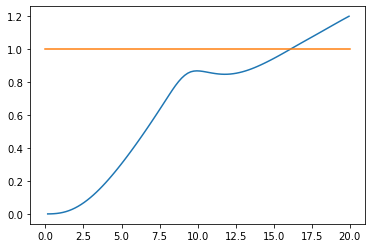

Episode * 195 * Avg Reward is ==> -21.452385580787695
-75.9371992393833


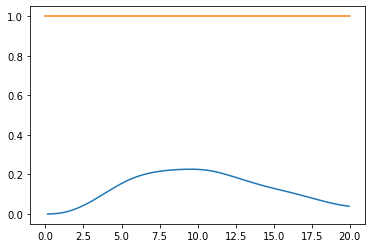

Episode * 196 * Avg Reward is ==> -27.26488107204893
-43.849456458760876


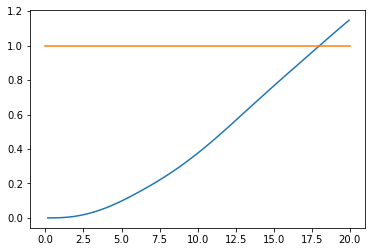

Episode * 197 * Avg Reward is ==> -29.601894894836438
-25.699744551150257


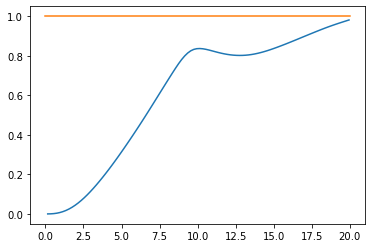

Episode * 198 * Avg Reward is ==> -30.003545302699706
-33.024746358872726


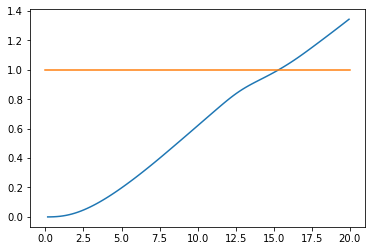

Episode * 199 * Avg Reward is ==> -30.813045042767413
-25.1913190357174


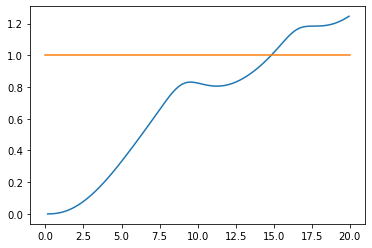

Episode * 200 * Avg Reward is ==> -30.944183232182155
-21.025072410901227


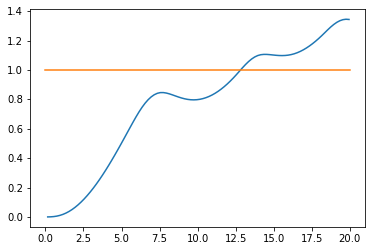

Episode * 201 * Avg Reward is ==> -31.12025860152325
-20.895274138687203


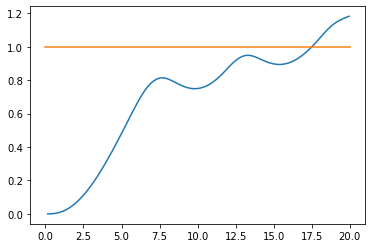

Episode * 202 * Avg Reward is ==> -31.20310605295618
-21.258333554526093


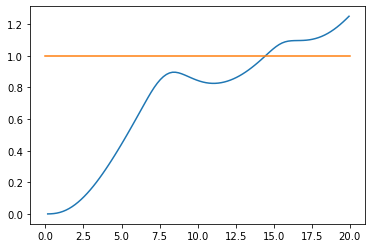

Episode * 203 * Avg Reward is ==> -31.378123851024732
-21.200823342207354


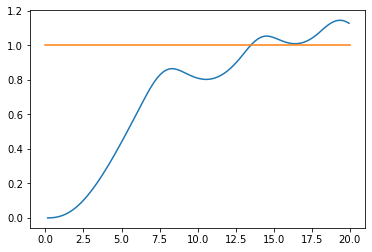

Episode * 204 * Avg Reward is ==> -31.354062415389528
-21.806534781530654


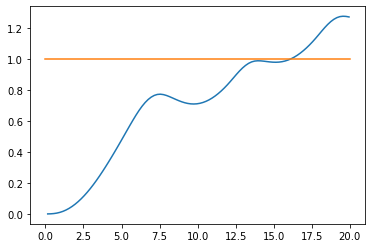

Episode * 205 * Avg Reward is ==> -30.98885038717371
-19.243995984795085


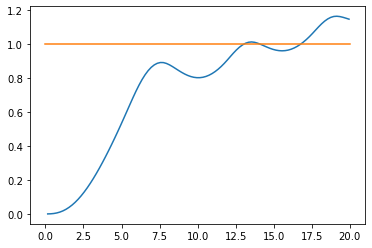

Episode * 206 * Avg Reward is ==> -25.319530061714886
-20.26920521909396


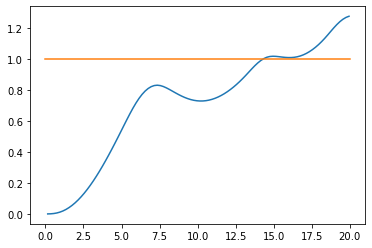

Episode * 207 * Avg Reward is ==> -22.961504937748195
-20.64516287753294


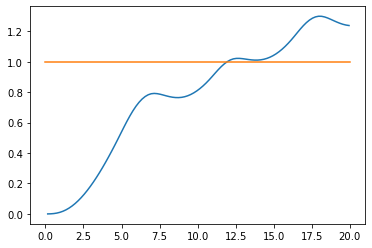

Episode * 208 * Avg Reward is ==> -22.45604677038646
-21.185052155177754


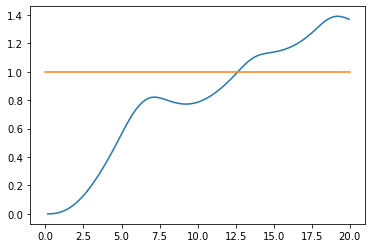

Episode * 209 * Avg Reward is ==> -21.272077350016964
-21.96053217938847


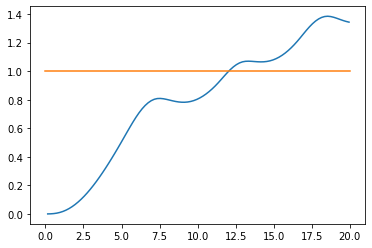

Episode * 210 * Avg Reward is ==> -20.948998664384074
-17.598051417578844


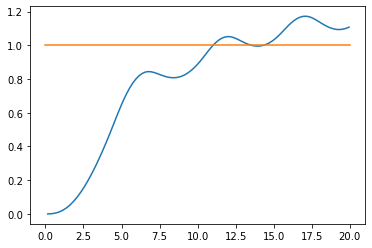

Episode * 211 * Avg Reward is ==> -20.60629656505184
-18.094281222967304


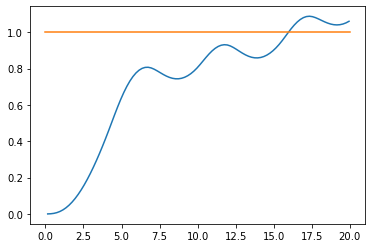

Episode * 212 * Avg Reward is ==> -20.326197273479846
-17.82858995510824


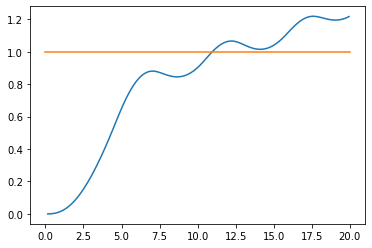

Episode * 213 * Avg Reward is ==> -19.98322291353806
-18.842667680576096


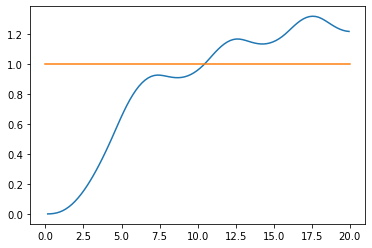

Episode * 214 * Avg Reward is ==> -19.74740734737493
-18.863797053206056


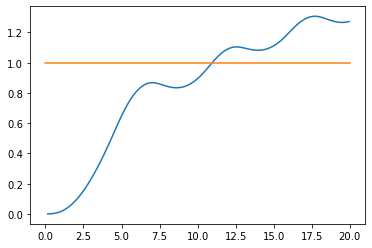

Episode * 215 * Avg Reward is ==> -19.45313357454247
-18.838535296044864


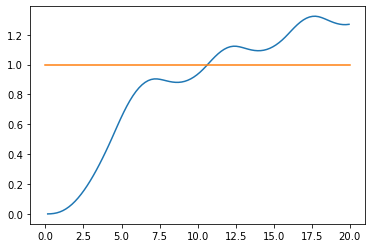

Episode * 216 * Avg Reward is ==> -19.412587505667453
-18.039013576882585


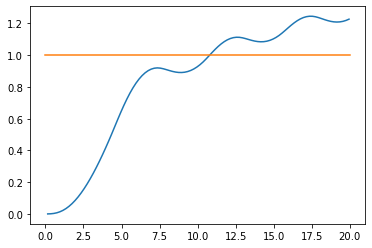

Episode * 217 * Avg Reward is ==> -19.18956834144631
-19.633627027858203


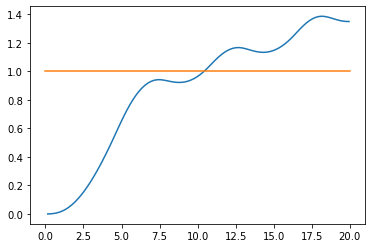

Episode * 218 * Avg Reward is ==> -19.08841475647884
-18.059619645141023


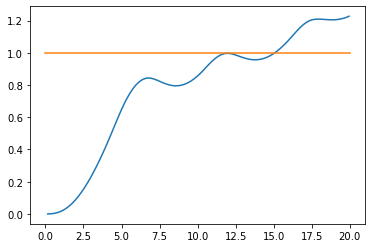

Episode * 219 * Avg Reward is ==> -18.77587150547517
-21.6556346867716


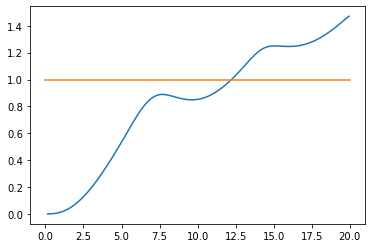

Episode * 220 * Avg Reward is ==> -18.745381756213483
-21.395847894444522


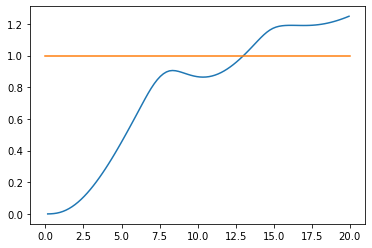

Episode * 221 * Avg Reward is ==> -19.12516140390005
-26.03051816564428


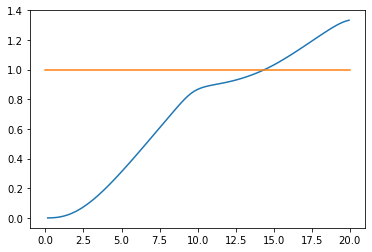

Episode * 222 * Avg Reward is ==> -19.918785098167746
-28.30432837775907


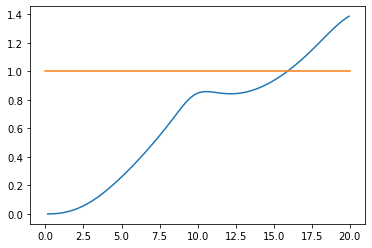

Episode * 223 * Avg Reward is ==> -20.96635894043283
-24.73888445849552


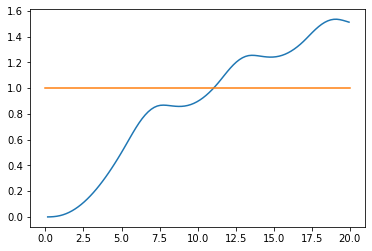

Episode * 224 * Avg Reward is ==> -21.555980618224773
-22.557887502086835


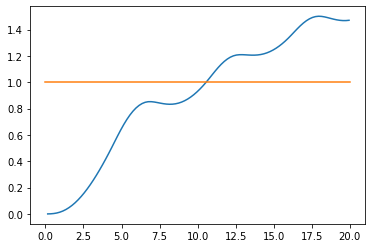

Episode * 225 * Avg Reward is ==> -21.92538966311285
-20.25023977184311


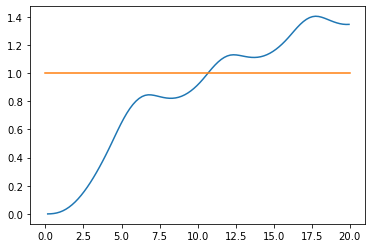

Episode * 226 * Avg Reward is ==> -22.06656011069267
-21.71413396802918


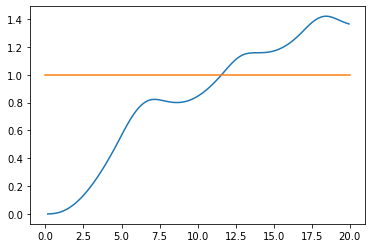

Episode * 227 * Avg Reward is ==> -22.434072149807335
-20.453845840869768


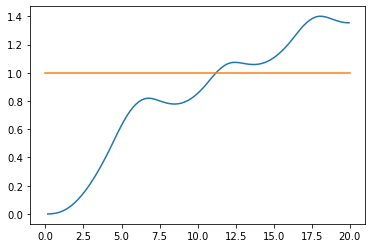

Episode * 228 * Avg Reward is ==> -22.51609403110849
-20.564999013264433


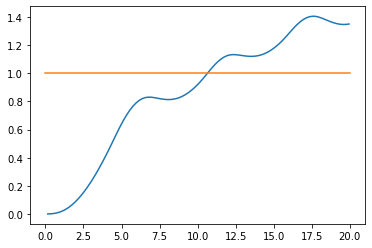

Episode * 229 * Avg Reward is ==> -22.766631967920834
-20.31084805216401


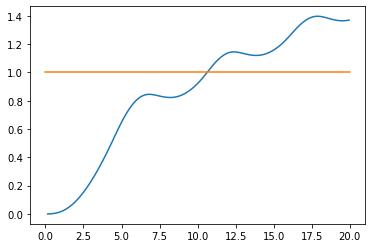

Episode * 230 * Avg Reward is ==> -22.632153304460072
-22.29000254089001


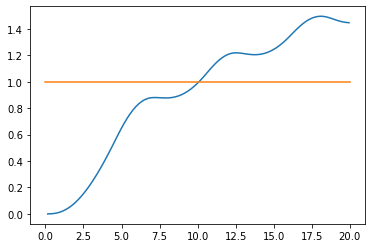

Episode * 231 * Avg Reward is ==> -22.72156876910462
-20.132987406460508


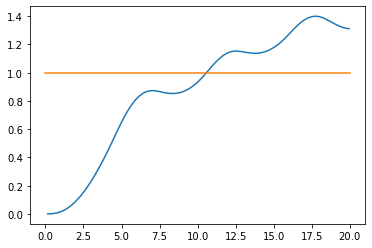

Episode * 232 * Avg Reward is ==> -22.131815693186248
-19.434980563792607


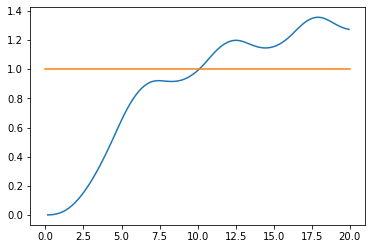

Episode * 233 * Avg Reward is ==> -21.244880911789597
-21.621161401954758


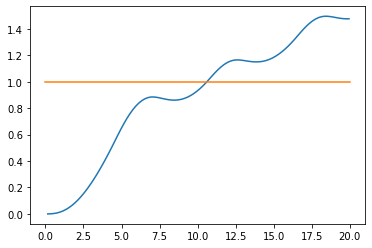

Episode * 234 * Avg Reward is ==> -20.933108606135523
-20.38392485407651


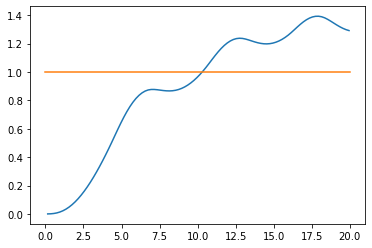

Episode * 235 * Avg Reward is ==> -20.715712341334488
-18.4055491901703


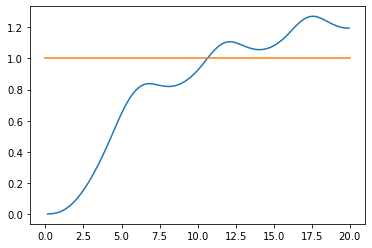

Episode * 236 * Avg Reward is ==> -20.531243283167207
-21.533119724052973


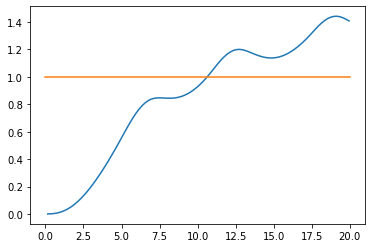

Episode * 237 * Avg Reward is ==> -20.513141858769586
-20.520593729779065


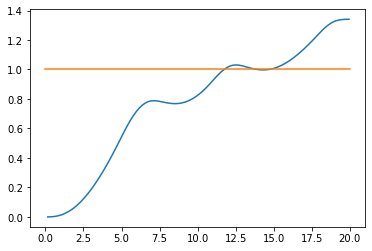

Episode * 238 * Avg Reward is ==> -20.51981664766052
-23.21395913036472


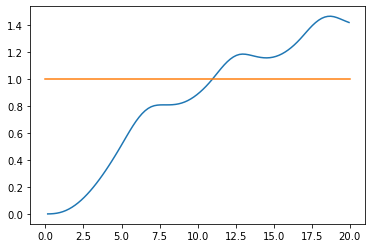

Episode * 239 * Avg Reward is ==> -20.784712659370545
-19.44812577170969


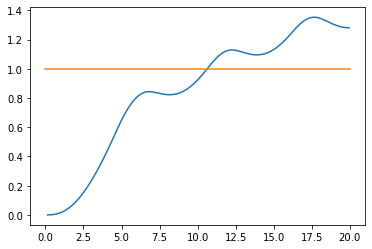

Episode * 240 * Avg Reward is ==> -20.698440431325118
-19.992841097809713


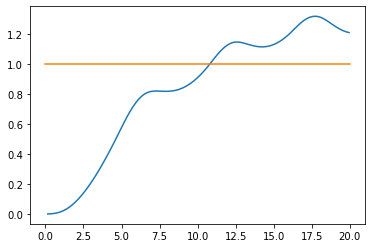

Episode * 241 * Avg Reward is ==> -20.468724287017086
-20.100111197323347


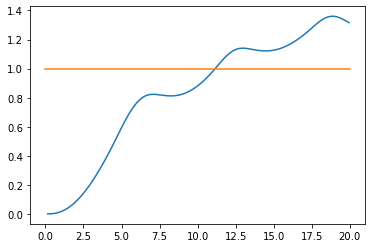

Episode * 242 * Avg Reward is ==> -20.46543666610337
-20.961981969303714


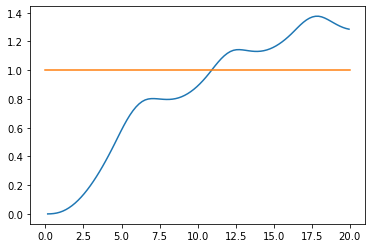

Episode * 243 * Avg Reward is ==> -20.61813680665448
-19.52527054741523


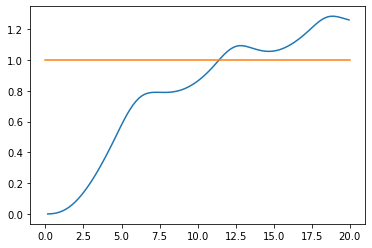

Episode * 244 * Avg Reward is ==> -20.408547721200527
-22.465341662164672


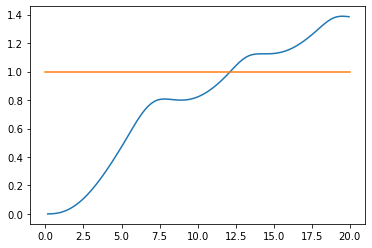

Episode * 245 * Avg Reward is ==> -20.61668940200934
-21.106596709404453


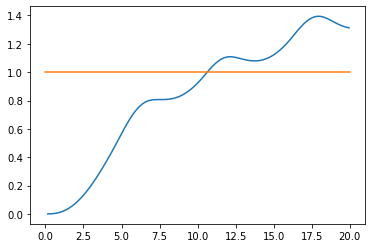

Episode * 246 * Avg Reward is ==> -20.886794153932755
-19.505142657889017


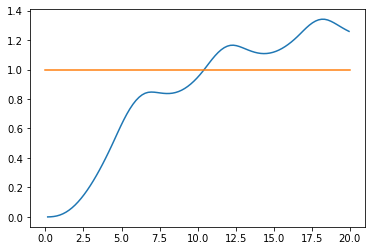

Episode * 247 * Avg Reward is ==> -20.683996447316364
-21.670339732262857


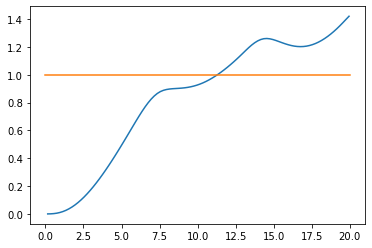

Episode * 248 * Avg Reward is ==> -20.79897104756474
-21.292431358577012


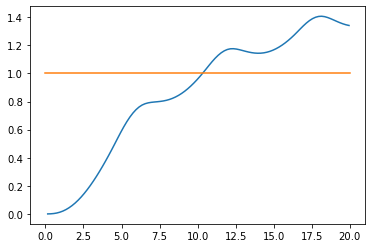

Episode * 249 * Avg Reward is ==> -20.60681827038597
-20.601225439918732


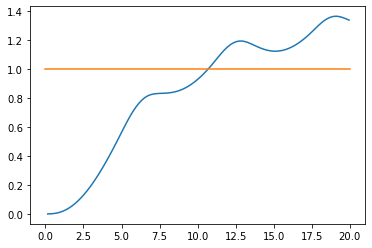

Episode * 250 * Avg Reward is ==> -20.722128237206874
-21.321793385139525


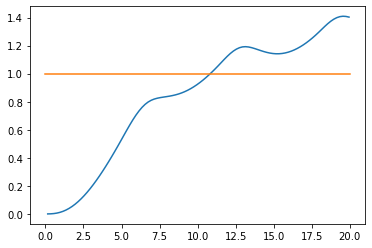

Episode * 251 * Avg Reward is ==> -20.855023465939855
-23.616562290505247


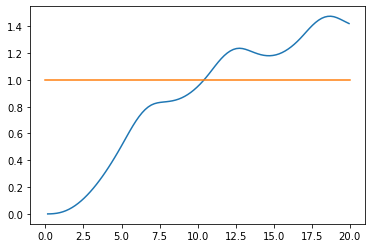

Episode * 252 * Avg Reward is ==> -21.206668575258046
-20.567494222960377


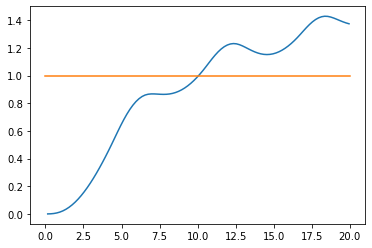

Episode * 253 * Avg Reward is ==> -21.167219800623712
-22.04067069376777


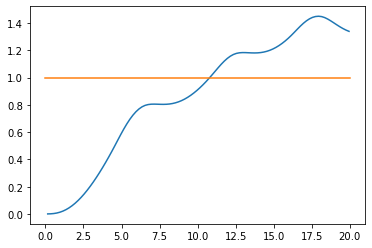

Episode * 254 * Avg Reward is ==> -21.418759815258966
-20.688751351332233


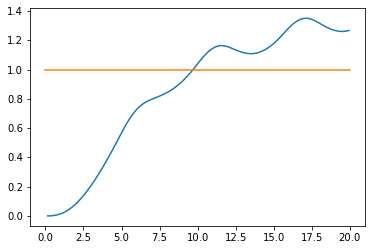

Episode * 255 * Avg Reward is ==> -21.24110078417572
-20.372467297186265


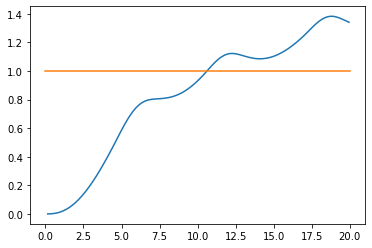

Episode * 256 * Avg Reward is ==> -21.167687842953903
-23.922315100941688


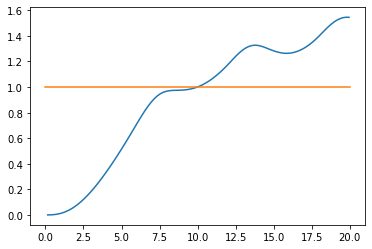

Episode * 257 * Avg Reward is ==> -21.60940508725917
-21.705538628201573


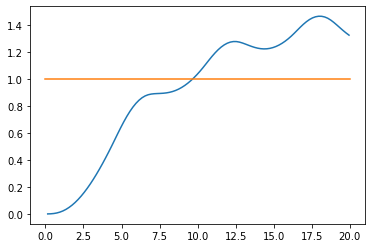

Episode * 258 * Avg Reward is ==> -21.61292497685304
-20.527359995084115


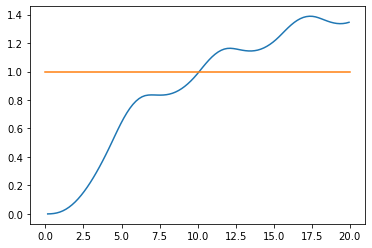

Episode * 259 * Avg Reward is ==> -21.536417840503752
-21.70956240558182


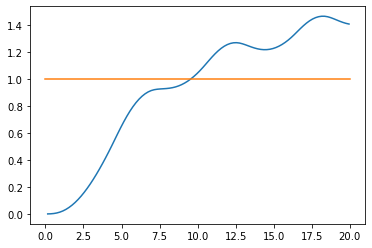

Episode * 260 * Avg Reward is ==> -21.64725153707006
-21.935758543030154


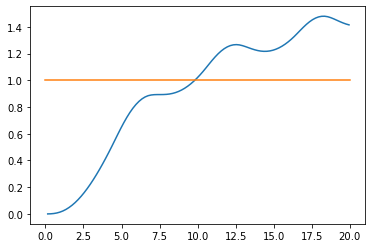

Episode * 261 * Avg Reward is ==> -21.708648052859125
-21.450274988580794


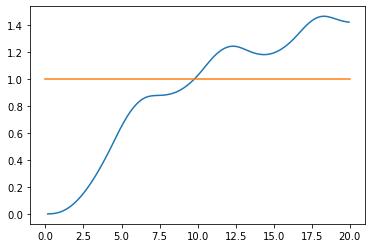

Episode * 262 * Avg Reward is ==> -21.49201932266668
-22.520093574197954


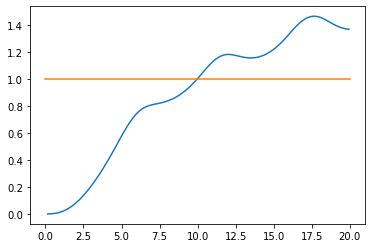

Episode * 263 * Avg Reward is ==> -21.687279257790433
-20.551958239220443


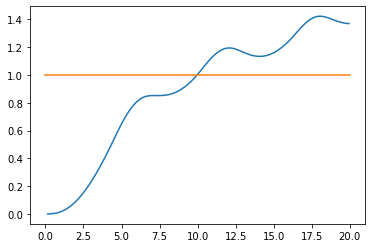

Episode * 264 * Avg Reward is ==> -21.5384080123357
-21.477954900655845


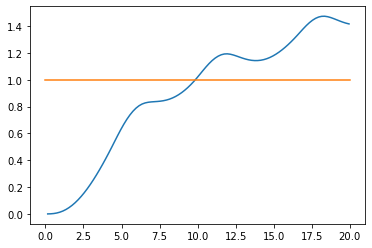

Episode * 265 * Avg Reward is ==> -21.617328367268065
-21.146344462155565


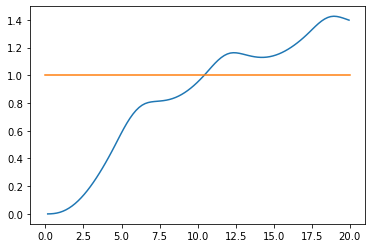

Episode * 266 * Avg Reward is ==> -21.694716083764995
-23.6985956399507


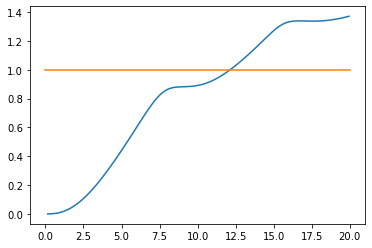

Episode * 267 * Avg Reward is ==> -21.672344137665895
-26.622598862318927


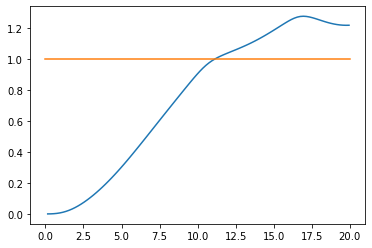

Episode * 268 * Avg Reward is ==> -22.164050161077633
-24.970263390459113


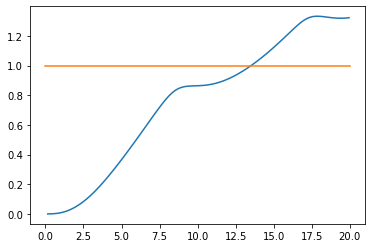

Episode * 269 * Avg Reward is ==> -22.60834050061513
-25.58501927170936


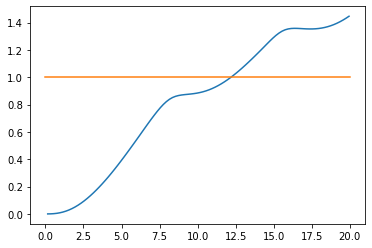

Episode * 270 * Avg Reward is ==> -22.995886187227885
-21.662301548649303


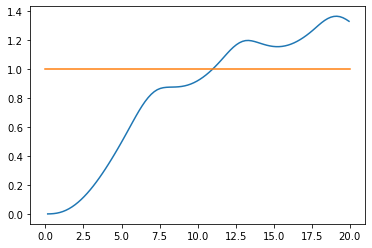

Episode * 271 * Avg Reward is ==> -22.968540487789802
-23.00520000844278


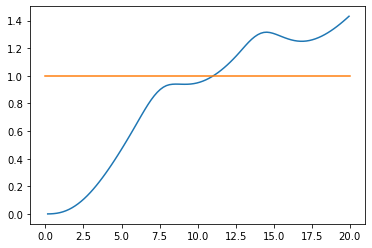

Episode * 272 * Avg Reward is ==> -23.124032989776
-24.12127189485906


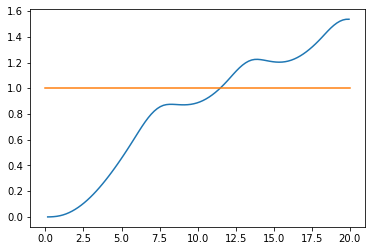

Episode * 273 * Avg Reward is ==> -23.28415082184211
-20.758193553192374


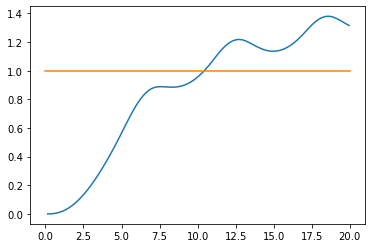

Episode * 274 * Avg Reward is ==> -23.304774353239303
-21.42816269686351


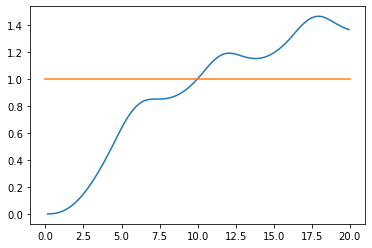

Episode * 275 * Avg Reward is ==> -23.299795132860066
-20.465935912452885


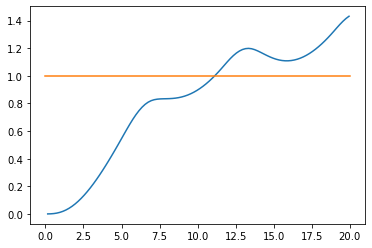

Episode * 276 * Avg Reward is ==> -23.231754277889802
-19.820885583328447


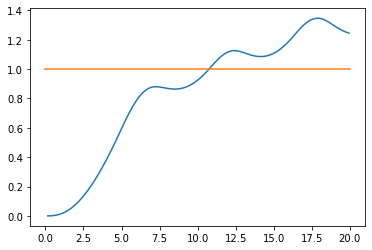

Episode * 277 * Avg Reward is ==> -22.843983272227575
-20.810920800626057


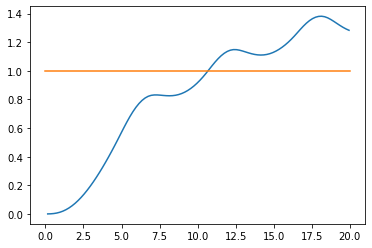

Episode * 278 * Avg Reward is ==> -22.26281546605829
-19.80958147980317


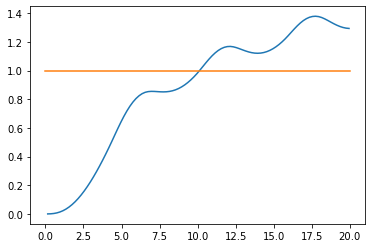

Episode * 279 * Avg Reward is ==> -21.746747274992693
-18.870712840355726


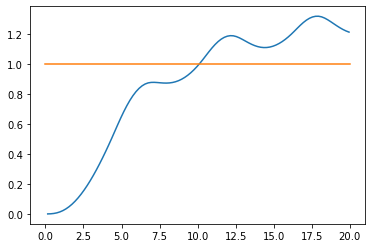

Episode * 280 * Avg Reward is ==> -21.075316631857334
-20.351060953251018


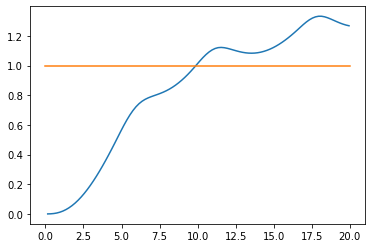

Episode * 281 * Avg Reward is ==> -20.9441925723175
-19.654669974350988


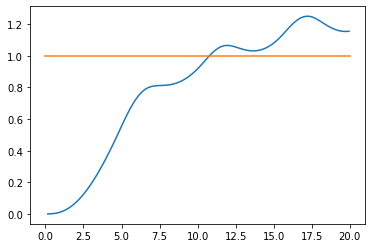

Episode * 282 * Avg Reward is ==> -20.609139568908322
-21.794190582807595


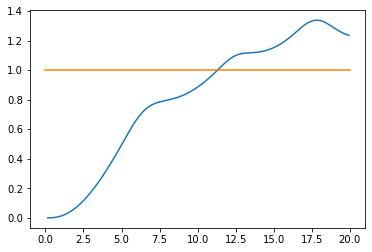

Episode * 283 * Avg Reward is ==> -20.376431437703175
-19.84066022195744


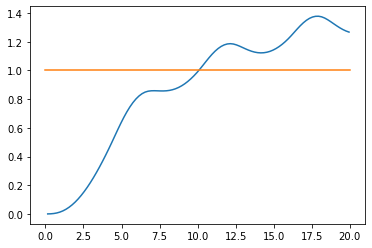

Episode * 284 * Avg Reward is ==> -20.284678104579683
-18.05442063500818


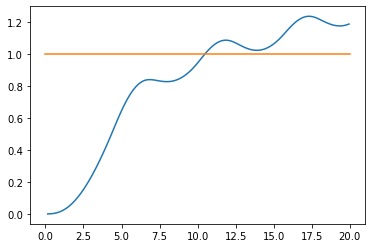

Episode * 285 * Avg Reward is ==> -19.94730389839415
-18.95112804431001


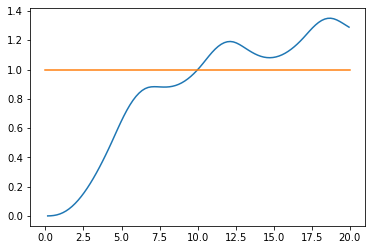

Episode * 286 * Avg Reward is ==> -19.795823111579857
-20.808911128898483


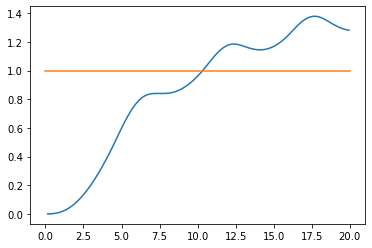

Episode * 287 * Avg Reward is ==> -19.894625666136868
-21.096068157682144


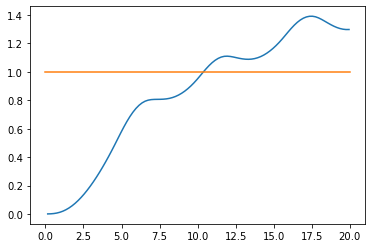

Episode * 288 * Avg Reward is ==> -19.923140401842474
-18.66025445651315


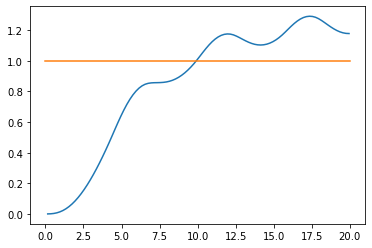

Episode * 289 * Avg Reward is ==> -19.80820769951347
-18.330795472158922


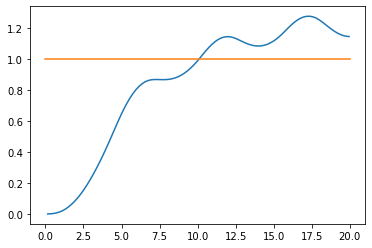

Episode * 290 * Avg Reward is ==> -19.75421596269379
-18.32361358037205


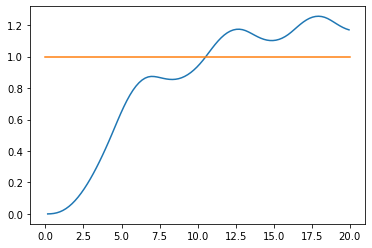

Episode * 291 * Avg Reward is ==> -19.551471225405894
-20.067857640288103


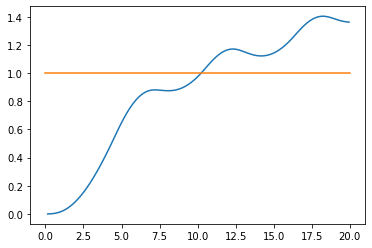

Episode * 292 * Avg Reward is ==> -19.59278999199961
-20.035983870383234


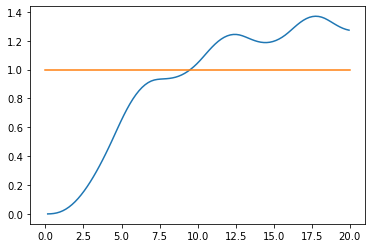

Episode * 293 * Avg Reward is ==> -19.416969320757172
-17.85673817604258


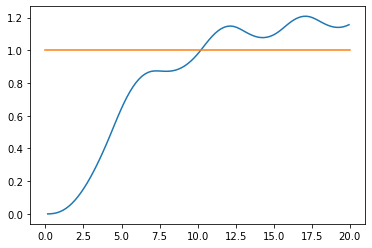

Episode * 294 * Avg Reward is ==> -19.218577116165683
-18.196641108083394


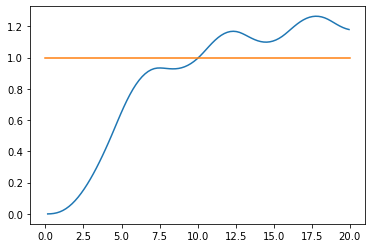

Episode * 295 * Avg Reward is ==> -19.232799163473207
-18.51355167858177


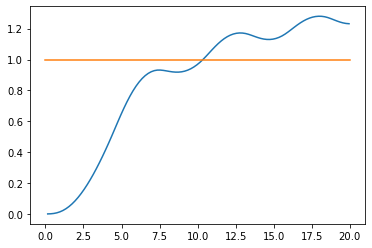

Episode * 296 * Avg Reward is ==> -19.18904152690038
-19.24148914742984


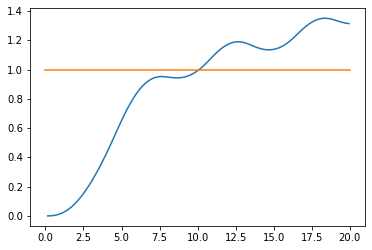

Episode * 297 * Avg Reward is ==> -19.032299328753517
-19.806365269985903


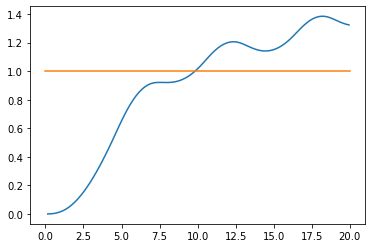

Episode * 298 * Avg Reward is ==> -18.903329039983895
-19.07340348519731


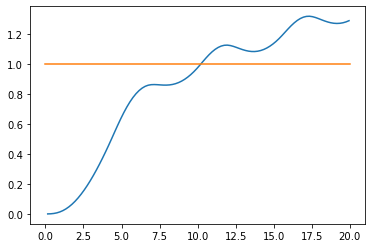

Episode * 299 * Avg Reward is ==> -18.944643942852313
-19.505456614923116


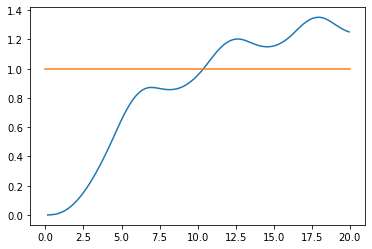

Episode * 300 * Avg Reward is ==> -19.062110057128727
-18.13005896904496


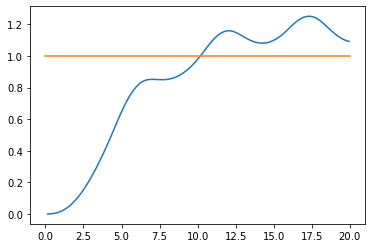

Episode * 301 * Avg Reward is ==> -19.04275459599602
-18.125111691467044


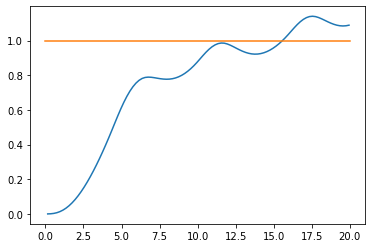

Episode * 302 * Avg Reward is ==> -18.848480001113916
-19.847010603352256


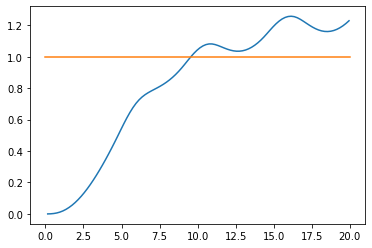

Episode * 303 * Avg Reward is ==> -18.82958267441082
-20.09936162702488


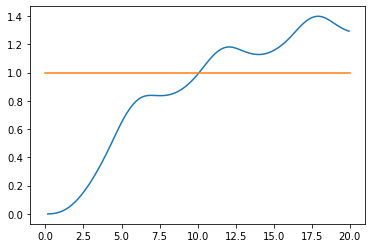

Episode * 304 * Avg Reward is ==> -19.053845019509048
-18.63852510666545


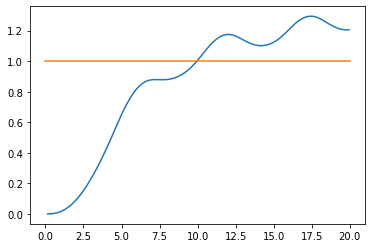

Episode * 305 * Avg Reward is ==> -19.09803341936725
-18.346431703023853


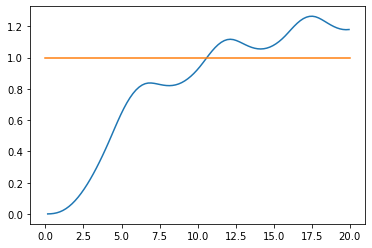

Episode * 306 * Avg Reward is ==> -19.08132142181146
-18.029082070876246


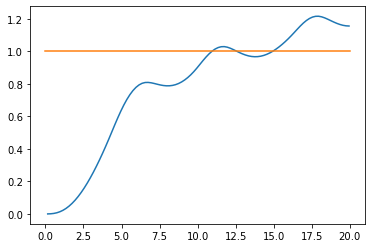

Episode * 307 * Avg Reward is ==> -18.960080714156103
-18.821541818429946


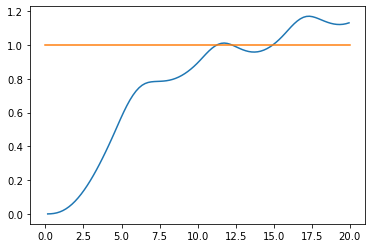

Episode * 308 * Avg Reward is ==> -18.86159836900051
-20.182453391464932


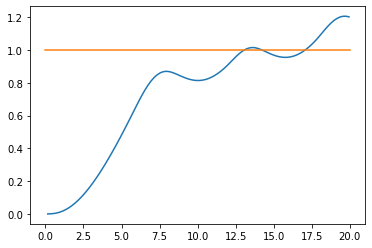

Episode * 309 * Avg Reward is ==> -18.972503359627268
-19.153840128904186


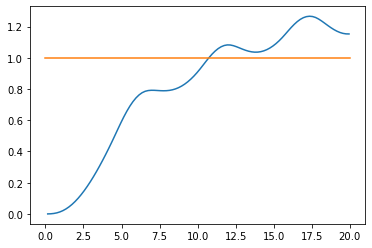

Episode * 310 * Avg Reward is ==> -18.937341711025375
-18.103160456715113


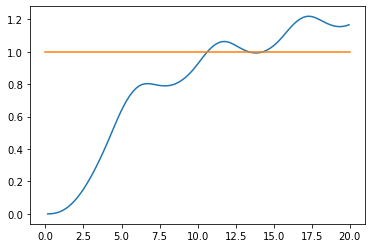

Episode * 311 * Avg Reward is ==> -18.93465185979239
-17.36590849216499


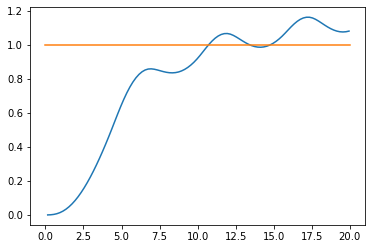

Episode * 312 * Avg Reward is ==> -18.858731539862184
-18.694995090582633


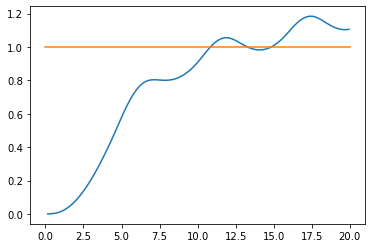

Episode * 313 * Avg Reward is ==> -18.743529988585223
-18.259952463567135


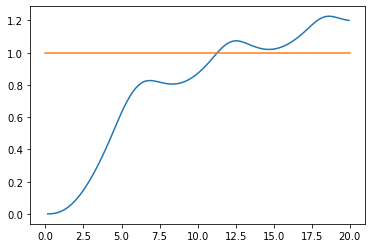

Episode * 314 * Avg Reward is ==> -18.55958907223945
-19.189672351362113


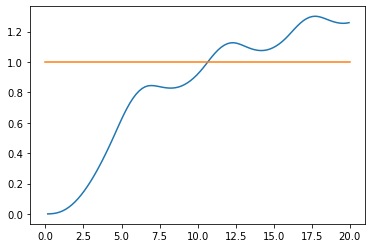

Episode * 315 * Avg Reward is ==> -18.614703796709115
-17.110275020350556


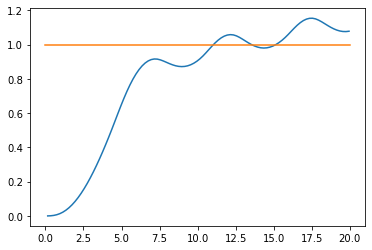

Episode * 316 * Avg Reward is ==> -18.49108812844179
-17.960398850927863


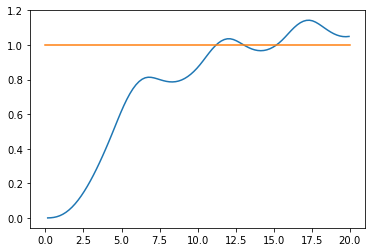

Episode * 317 * Avg Reward is ==> -18.48421980644695
-18.288092068315848


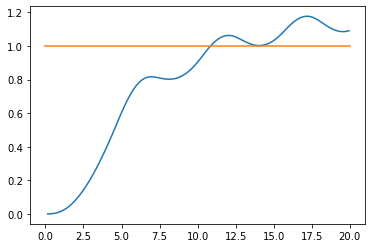

Episode * 318 * Avg Reward is ==> -18.43087483143554
-18.429666537476898


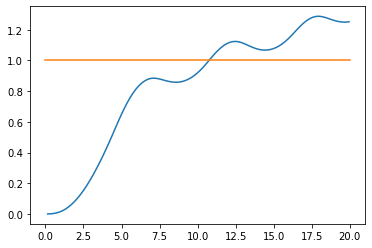

Episode * 319 * Avg Reward is ==> -18.255596146036734
-17.84411872860026


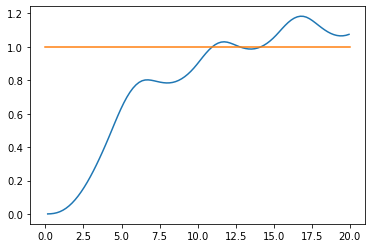

Episode * 320 * Avg Reward is ==> -18.124624006006336
-18.510921996015266


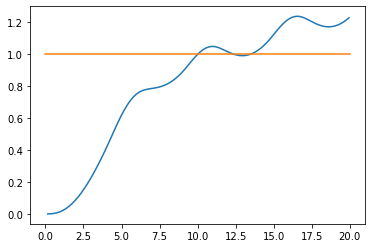

Episode * 321 * Avg Reward is ==> -18.165400159936357
-17.597930664662496


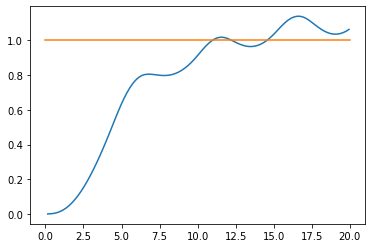

Episode * 322 * Avg Reward is ==> -18.188602377186108
-17.51501778542269


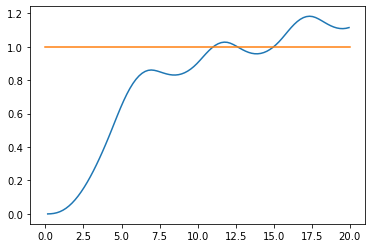

Episode * 323 * Avg Reward is ==> -18.070604646670112
-17.934052479771797


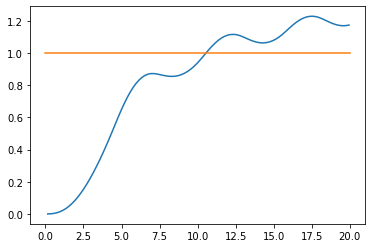

Episode * 324 * Avg Reward is ==> -18.038014648290577
-19.06420940262638


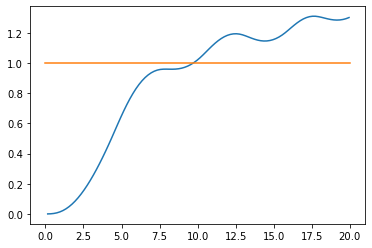

Episode * 325 * Avg Reward is ==> -18.025468353417004
-18.74406944645912


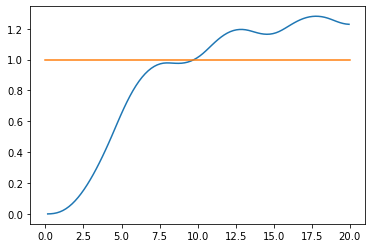

Episode * 326 * Avg Reward is ==> -18.18884779602786
-20.92536592320627


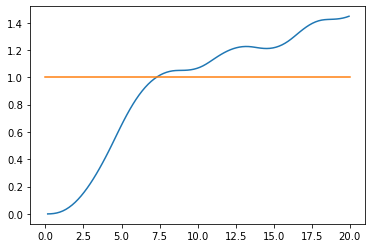

Episode * 327 * Avg Reward is ==> -18.485344503255703
-17.864862363616844


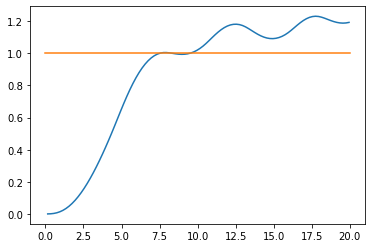

Episode * 328 * Avg Reward is ==> -18.4430215327858
-18.19025529411351


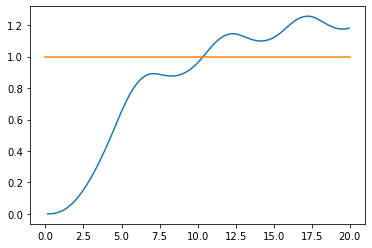

Episode * 329 * Avg Reward is ==> -18.419080408449464
-17.64307802009748


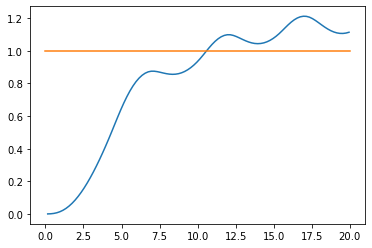

Episode * 330 * Avg Reward is ==> -18.398976337599187
-18.86821229108339


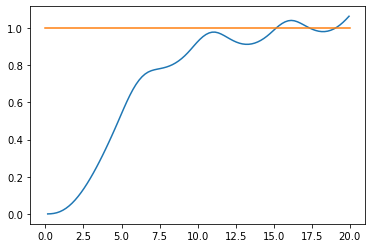

Episode * 331 * Avg Reward is ==> -18.434705367105995
-19.851175868118336


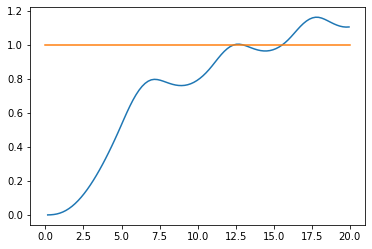

Episode * 332 * Avg Reward is ==> -18.66002988745158
-18.40193817402307


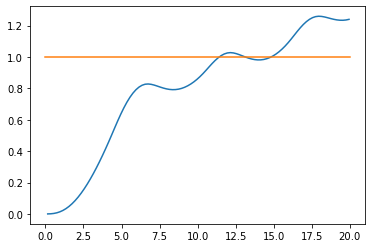

Episode * 333 * Avg Reward is ==> -18.748721926311617
-17.619236569937847


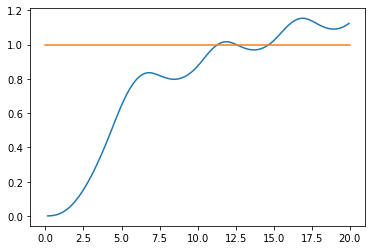

Episode * 334 * Avg Reward is ==> -18.71724033532822
-18.102367832655755


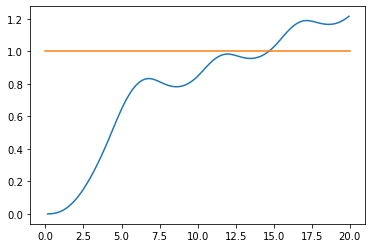

Episode * 335 * Avg Reward is ==> -18.621056178331163
-18.24680755729412


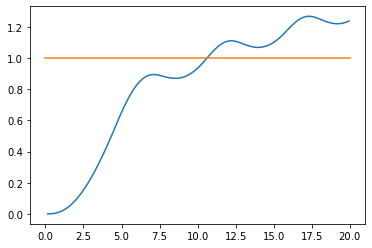

Episode * 336 * Avg Reward is ==> -18.57132998941466
-17.237709192226674


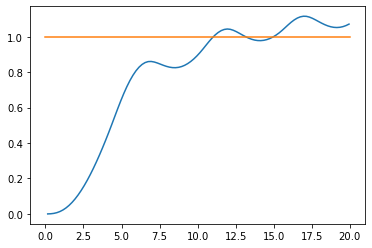

Episode * 337 * Avg Reward is ==> -18.202564316316703
-18.43707877837369


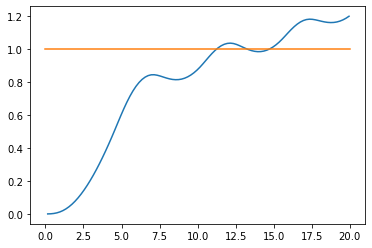

Episode * 338 * Avg Reward is ==> -18.259785957792385
-17.905562117722422


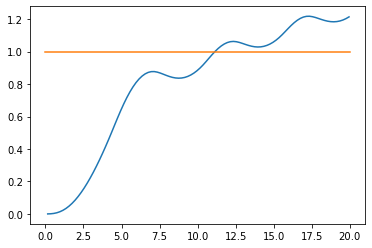

Episode * 339 * Avg Reward is ==> -18.231316640153278
-17.78562444940933


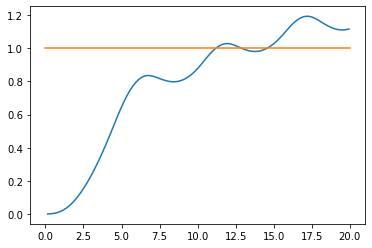

Episode * 340 * Avg Reward is ==> -18.245571283084463
-20.78396665987921


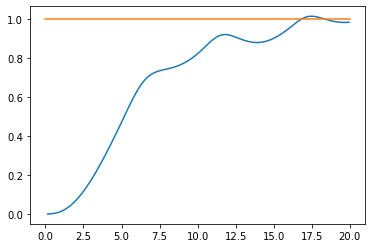

Episode * 341 * Avg Reward is ==> -18.437146719964048
-27.32196342056873


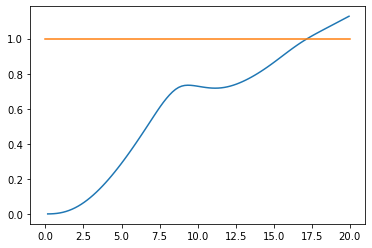

Episode * 342 * Avg Reward is ==> -19.184225475209082
-29.47828424550179


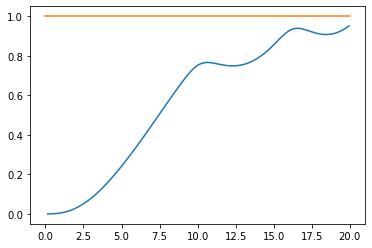

Episode * 343 * Avg Reward is ==> -20.291860082356955
-22.727788703023123


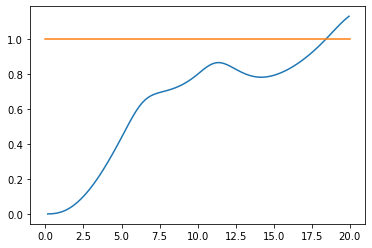

Episode * 344 * Avg Reward is ==> -20.802715295665482
-22.66800720578901


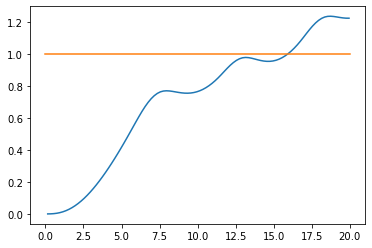

Episode * 345 * Avg Reward is ==> -21.25927923297881
-18.645732214192467


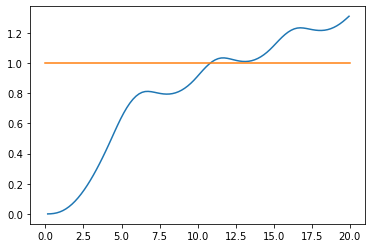

Episode * 346 * Avg Reward is ==> -21.299171698668644
-17.840251562892902


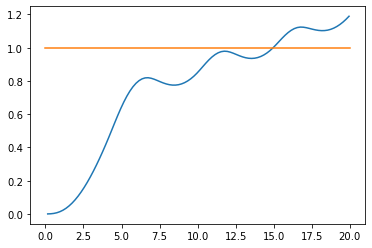

Episode * 347 * Avg Reward is ==> -21.359425935735267
-19.813375160627626


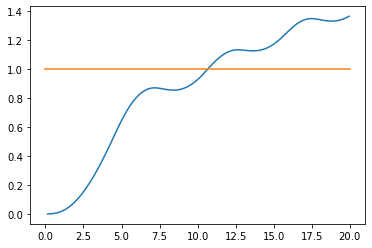

Episode * 348 * Avg Reward is ==> -21.497055573960658
-17.427062261808207


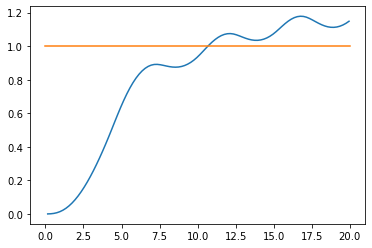

Episode * 349 * Avg Reward is ==> -21.44920558836924
-19.10313495545768


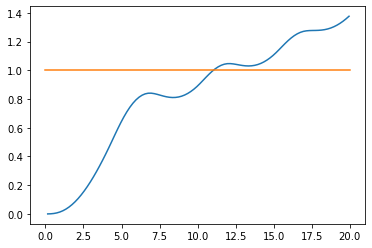

Episode * 350 * Avg Reward is ==> -21.580956638974072
-17.499075513814788


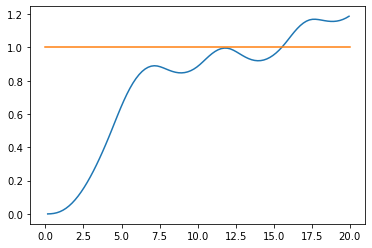

Episode * 351 * Avg Reward is ==> -21.25246752436763
-17.50342830757563


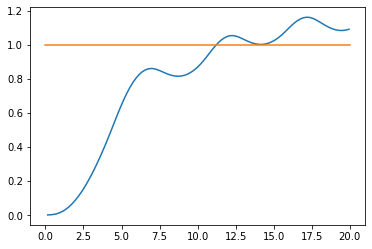

Episode * 352 * Avg Reward is ==> -20.270614013068325
-18.623261616850552


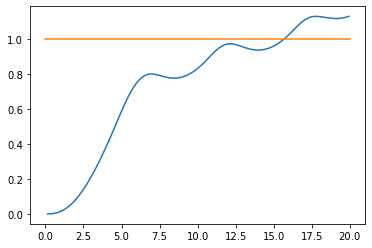

Episode * 353 * Avg Reward is ==> -19.1851117502032
-20.549831033220904


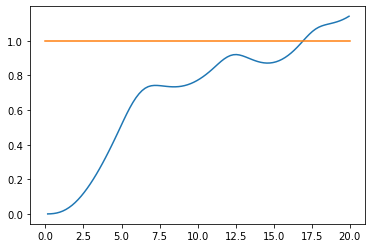

Episode * 354 * Avg Reward is ==> -18.967315983222978
-19.48669723622682


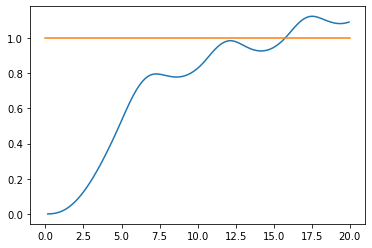

Episode * 355 * Avg Reward is ==> -18.649184986266754
-19.759873953007514


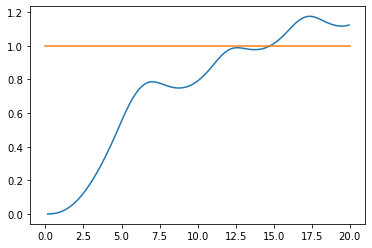

Episode * 356 * Avg Reward is ==> -18.760599160148267
-19.078055835129717


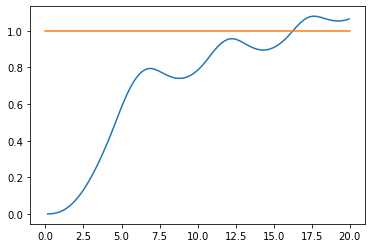

Episode * 357 * Avg Reward is ==> -18.884379587371946
-21.485241935619207


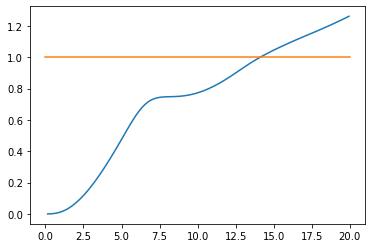

Episode * 358 * Avg Reward is ==> -19.051566264871102
-27.589256333067993


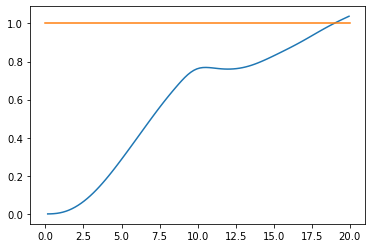

Episode * 359 * Avg Reward is ==> -20.06778567199708
-26.45946527910629


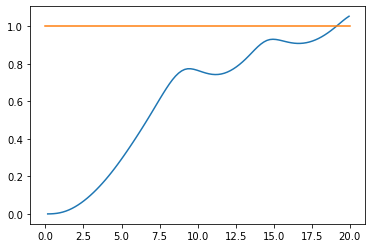

Episode * 360 * Avg Reward is ==> -20.80341870436194
-21.680389792597733


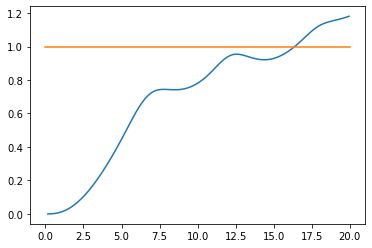

Episode * 361 * Avg Reward is ==> -21.22155013224024
-23.636124296778025


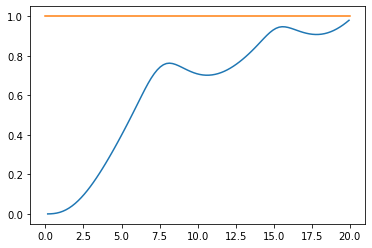

Episode * 362 * Avg Reward is ==> -21.834819731160476
-23.404765217891065


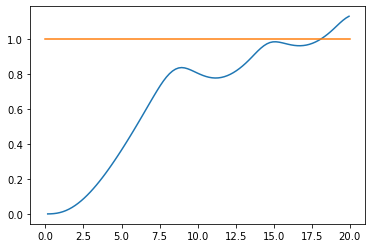

Episode * 363 * Avg Reward is ==> -22.31297009126453
-20.121322163215158


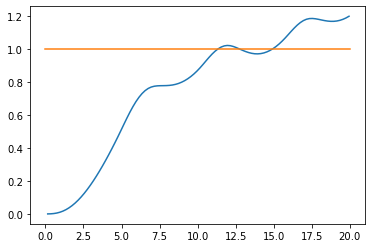

Episode * 364 * Avg Reward is ==> -22.27011920426395
-20.548297683323103


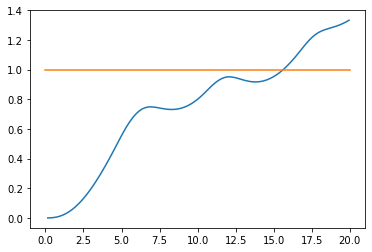

Episode * 365 * Avg Reward is ==> -22.37627924897358


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-94c8319c8a64>", line 23, in <module>
    hiba,kimenet,ido=simulation_step(float(action[0]),timesteps)
  File "<ipython-input-21-ed1fe9890875>", line 3, in simulation_step
    eng.set_param(model,'SimulationCommand','update',nargout=0) #szimulációs paraméterek beírása
  File "C:\ProgramData\Anaconda3\lib\site-packages\matlab\engine\matlabengine.py", line 64, in __call__
    future = pythonengine.evaluateFunction(self._engine()._matlab,
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_r

TypeError: object of type 'NoneType' has no len()

In [30]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes much more than 4 min to train
for ep in range(total_episodes):#for each episode

    #prev_state = env.reset() ehelyett legyen:
    prev_state = np.array([0,1.,1,1,1,1,1]) #ido+6db elmúlt hiba kezdetben mind 1    
    episodic_reward = 0
    #eng.workspace['actuator']=1.0 #kezdeti init és paraméter átadás a workspacenek-------------------------------------------------
    #eng.set_param(model, 'SimulationCommand', 'start', nargout=0)#Simulink modell elindítása
    timesteps=0
    #simulation_step(1.0,timesteps)#elindítjuk a szimulációt
    #debugg miatt modell plotolásához adatok
    x=[]
    y=[]
    while (eng.get_param(model,'SimulationStatus')!=('stopped' or 'terminating')) and (max_steps_per_episode>timesteps) or timesteps==0:# one episode

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action =policy(tf_prev_state, ou_noise)
        hiba,kimenet,ido=simulation_step(float(action[0]),timesteps)                                 
        state, reward, done = step_value(hiba,prev_state,ido)
                                         
        #print(timesteps)                                 
        #print(kimenet)
        #print(prev_state)
        #print(float(action[0]))
        
        x.append(ido)
        y.append(kimenet)
        #hibak.append(hiba)
        timesteps=timesteps+1

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state
        
    #adott episode végett ér
    eng.set_param(model,'SimulationCommand','stop',nargout=0)
    plt.plot(x,y)
    print(episodic_reward)
    x_coordinates = [0, 20]
    y_coordinates = [1, 1]
    plt.plot(x_coordinates,y_coordinates)
    plt.show()
    ep_reward_list.append(episodic_reward)

    # Mean of last 10 episodes
    avg_reward = np.mean(ep_reward_list[-10:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()